In [1]:
from timeseries_ml_utils.data import DataFetcher, DataGenerator
from scipy.fftpack import dct, idct
from keras.models import Sequential, model_from_json
from keras.layers import Input, Dense, GRU, Embedding, LSTM
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras.utils import plot_model
from keras.callbacks import TensorBoard
import keras
import matplotlib.pyplot as plt
import re

Using TensorFlow backend.


In [2]:
# fetch data
data = DataFetcher(["GLD.US"])
data.fetch_data().tail()


,GLD.US.Open,GLD.US.High,GLD.US.Low,GLD.US.Close,GLD.US.Volume
Date,,,,,
2018-11-12,114.01,114.05,113.58,113.66,7499046
2018-11-13,113.72,113.93,113.42,113.70,9309074
2018-11-14,113.53,115.06,113.46,114.64,13950218
2018-11-15,114.83,114.99,114.56,114.77,8910585
2018-11-16,115.83,115.88,115.37,115.62,8576955


In [9]:
model_data = DataGenerator(data.get_dataframe(), ['.*'], ["GLD.US.Close$"], aggregation_window_size=16)
print(model_data.batch_feature_shape)
print(model_data.batch_label_shape)
model_data.features, model_data.labels


(100, 260, 320)
(100, 16)


(['GLD.US.Open',
  'GLD.US.High',
  'GLD.US.Low',
  'GLD.US.Close',
  'GLD.US.Volume',
  'GLD.US.Open_variance',
  'GLD.US.High_variance',
  'GLD.US.Low_variance',
  'GLD.US.Close_variance',
  'GLD.US.Volume_variance',
  'cos_dow',
  'sin_dow',
  'cos_woy',
  'sin_woy',
  'cos_doy',
  'sin_doy',
  'sin_yer',
  'cos_yer',
  'sin_dec',
  'cos_dec'],
 ['GLD.US.Close'])

In [10]:
model = Sequential()
model.add(LSTM(model_data.batch_label_shape[-1],
          batch_input_shape=model_data.batch_feature_shape,
          activation='tanh',
          dropout=0,
          recurrent_dropout=0,
          stateful = True,
          return_sequences=model_data.return_sequences))

model.compile("Adam", loss="mse")
print(model.layers[0].get_weights()[0][0])



[ 0.08326632  0.06887084 -0.04321939 -0.11705196  0.11586741  0.11280322
 -0.07714772 -0.12433612 -0.12265295 -0.05920169 -0.014034    0.08582687
  0.01569641 -0.09265301 -0.12267795  0.07152098  0.04708919  0.08932719
 -0.09574035  0.11358488  0.09033468 -0.02042884 -0.06701922 -0.10406005
  0.02760968  0.07731837  0.02026701 -0.12405756 -0.08166093  0.07439288
  0.09032306  0.04631749 -0.01443684 -0.04988262  0.04765561 -0.11603859
 -0.00963226  0.08800718 -0.00807476 -0.08350331 -0.05877715  0.09847859
 -0.00894111 -0.00097615  0.05570915 -0.0543887  -0.08725303  0.01518419
  0.07730398 -0.04937315 -0.0432629  -0.10141695  0.05286396 -0.03641948
 -0.01554456 -0.05757001  0.09707507  0.1175662  -0.07781091 -0.05184954
  0.01239491  0.11719212  0.08650815  0.11970854]


In [11]:

hist = model.fit_generator(generator=model_data,
                           validation_data=model_data.as_test_data_generator(model),
                           epochs=1,
                           use_multiprocessing=True,
                           workers=1,
                           shuffle=False,
                           callbacks=[TensorBoard(log_dir='./logs')])


Epoch 1/1

   1/1488 [..............................] - ETA: 37:30 - loss: 20145.1562

   2/1488 [..............................] - ETA: 28:04 - loss: 20169.0859

   3/1488 [..............................] - ETA: 26:00 - loss: 20192.8503

   4/1488 [..............................] - ETA: 25:15 - loss: 20216.4810

   5/1488 [..............................] - ETA: 24:37 - loss: 20240.1262

   6/1488 [..............................] - ETA: 23:53 - loss: 20263.7757

   7/1488 [..............................] - ETA: 23:32 - loss: 20287.4738

   8/1488 [..............................] - ETA: 23:22 - loss: 20311.1909

   9/1488 [..............................] - ETA: 23:25 - loss: 20334.9457

  10/1488 [..............................] - ETA: 23:06 - loss: 20358.7129

  11/1488 [..............................] - ETA: 22:56 - loss: 20382.4984

  12/1488 [..............................] - ETA: 22:31 - loss: 20406.2428

  13/1488 [..............................] - ETA: 22:16 - loss: 20429.9878

  14/1488 [..............................] - ETA: 22:03 - loss: 20453.7963

  15/1488 [..............................] - ETA: 21:54 - loss: 20477.7128

  16/1488 [..............................] - ETA: 21:44 - loss: 20501.7119

  17/1488 [..............................] - ETA: 21:35 - loss: 20525.8166

  18/1488 [..............................] - ETA: 21:27 - loss: 20550.0442

  19/1488 [..............................] - ETA: 21:21 - loss: 20574.4445

  20/1488 [..............................] - ETA: 21:13 - loss: 20599.0157

  21/1488 [..............................] - ETA: 21:07 - loss: 20623.7624

  22/1488 [..............................] - ETA: 21:00 - loss: 20648.6840

  23/1488 [..............................] - ETA: 20:53 - loss: 20673.7627

  24/1488 [..............................] - ETA: 20:49 - loss: 20699.0426

  25/1488 [..............................] - ETA: 20:44 - loss: 20724.5313

  26/1488 [..............................] - ETA: 20:40 - loss: 20750.2235

  27/1488 [..............................] - ETA: 20:37 - loss: 20776.1401

  28/1488 [..............................] - ETA: 20:33 - loss: 20802.3523

  29/1488 [..............................] - ETA: 20:30 - loss: 20828.9197

  30/1488 [..............................] - ETA: 20:27 - loss: 20855.9331

  31/1488 [..............................] - ETA: 20:26 - loss: 20883.4353

  32/1488 [..............................] - ETA: 20:21 - loss: 20911.4732

  33/1488 [..............................] - ETA: 20:20 - loss: 20940.0916

  34/1488 [..............................] - ETA: 20:16 - loss: 20969.3476

  35/1488 [..............................] - ETA: 20:12 - loss: 20999.2833

  36/1488 [..............................] - ETA: 20:10 - loss: 21029.9595

  37/1488 [..............................] - ETA: 20:07 - loss: 21061.4524

  38/1488 [..............................] - ETA: 20:04 - loss: 21093.8555

  39/1488 [..............................] - ETA: 20:04 - loss: 21127.1852

  40/1488 [..............................] - ETA: 20:03 - loss: 21161.4355

  41/1488 [..............................] - ETA: 20:02 - loss: 21196.5862

  42/1488 [..............................] - ETA: 19:59 - loss: 21232.6458

  43/1488 [..............................] - ETA: 19:59 - loss: 21269.5749

  44/1488 [..............................] - ETA: 19:58 - loss: 21307.3580

  45/1488 [..............................] - ETA: 19:56 - loss: 21345.9548

  46/1488 [..............................] - ETA: 19:54 - loss: 21385.3070

  47/1488 [..............................] - ETA: 19:52 - loss: 21425.4139

  48/1488 [..............................] - ETA: 19:50 - loss: 21466.2855

  49/1488 [..............................] - ETA: 19:49 - loss: 21507.8835

  50/1488 [>.............................] - ETA: 19:56 - loss: 21550.1714

  51/1488 [>.............................] - ETA: 20:06 - loss: 21593.1155

  52/1488 [>.............................] - ETA: 20:04 - loss: 21636.6528

  53/1488 [>.............................] - ETA: 20:02 - loss: 21680.7079

  54/1488 [>.............................] - ETA: 20:01 - loss: 21725.1941

  55/1488 [>.............................] - ETA: 20:00 - loss: 21770.0405

  56/1488 [>.............................] - ETA: 20:00 - loss: 21815.2252

  57/1488 [>.............................] - ETA: 19:59 - loss: 21860.7135

  58/1488 [>.............................] - ETA: 19:57 - loss: 21906.4563

  59/1488 [>.............................] - ETA: 19:56 - loss: 21952.4086

  60/1488 [>.............................] - ETA: 19:55 - loss: 21998.4995

  61/1488 [>.............................] - ETA: 19:54 - loss: 22044.6392

  62/1488 [>.............................] - ETA: 19:52 - loss: 22090.7439

  63/1488 [>.............................] - ETA: 19:50 - loss: 22136.7355

  64/1488 [>.............................] - ETA: 19:48 - loss: 22182.5222

  65/1488 [>.............................] - ETA: 19:47 - loss: 22228.0503

  66/1488 [>.............................] - ETA: 19:46 - loss: 22273.2391

  67/1488 [>.............................] - ETA: 19:45 - loss: 22318.0381

  68/1488 [>.............................] - ETA: 19:43 - loss: 22362.4062

  69/1488 [>.............................] - ETA: 19:42 - loss: 22406.3038

  70/1488 [>.............................] - ETA: 19:41 - loss: 22449.7110

  71/1488 [>.............................] - ETA: 19:39 - loss: 22492.5975

  72/1488 [>.............................] - ETA: 19:44 - loss: 22534.9521

  73/1488 [>.............................] - ETA: 19:47 - loss: 22576.7788

  74/1488 [>.............................] - ETA: 19:44 - loss: 22618.0704

  75/1488 [>.............................] - ETA: 19:42 - loss: 22658.8209

  76/1488 [>.............................] - ETA: 19:41 - loss: 22699.0418

  77/1488 [>.............................] - ETA: 19:40 - loss: 22738.7648

  78/1488 [>.............................] - ETA: 19:38 - loss: 22778.0164

  79/1488 [>.............................] - ETA: 19:38 - loss: 22816.7988

  80/1488 [>.............................] - ETA: 19:41 - loss: 22855.1296

  81/1488 [>.............................] - ETA: 19:48 - loss: 22893.0235

  82/1488 [>.............................] - ETA: 19:57 - loss: 22930.4977

  83/1488 [>.............................] - ETA: 20:00 - loss: 22967.5646

  84/1488 [>.............................] - ETA: 19:59 - loss: 23004.2624

  85/1488 [>.............................] - ETA: 19:57 - loss: 23040.6164

  86/1488 [>.............................] - ETA: 19:55 - loss: 23076.6504

  87/1488 [>.............................] - ETA: 19:53 - loss: 23112.3859

  88/1488 [>.............................] - ETA: 19:52 - loss: 23147.8335

  89/1488 [>.............................] - ETA: 19:50 - loss: 23183.0151

  90/1488 [>.............................] - ETA: 19:48 - loss: 23217.9564

  91/1488 [>.............................] - ETA: 19:47 - loss: 23252.6841

  92/1488 [>.............................] - ETA: 19:45 - loss: 23287.2313

  93/1488 [>.............................] - ETA: 19:44 - loss: 23321.6214

  94/1488 [>.............................] - ETA: 19:43 - loss: 23355.8787

  95/1488 [>.............................] - ETA: 19:41 - loss: 23390.0294

  96/1488 [>.............................] - ETA: 19:40 - loss: 23424.1150

  97/1488 [>.............................] - ETA: 19:39 - loss: 23458.1631

  98/1488 [>.............................] - ETA: 19:36 - loss: 23492.2087

  99/1488 [>.............................] - ETA: 19:35 - loss: 23526.2729

 100/1488 [=>............................] - ETA: 19:36 - loss: 23560.3609

 101/1488 [=>............................] - ETA: 19:37 - loss: 23594.4718

 102/1488 [=>............................] - ETA: 19:38 - loss: 23628.6055

 103/1488 [=>............................] - ETA: 19:38 - loss: 23662.7670

 104/1488 [=>............................] - ETA: 19:38 - loss: 23696.9535

 105/1488 [=>............................] - ETA: 19:38 - loss: 23731.1444

 106/1488 [=>............................] - ETA: 19:38 - loss: 23765.3326

 107/1488 [=>............................] - ETA: 19:37 - loss: 23799.5086

 108/1488 [=>............................] - ETA: 19:36 - loss: 23833.6611

 109/1488 [=>............................] - ETA: 19:34 - loss: 23867.7726

 110/1488 [=>............................] - ETA: 19:32 - loss: 23901.8362

 111/1488 [=>............................] - ETA: 19:31 - loss: 23935.8388

 112/1488 [=>............................] - ETA: 19:30 - loss: 23969.7677

 113/1488 [=>............................] - ETA: 19:29 - loss: 24003.6018

 114/1488 [=>............................] - ETA: 19:28 - loss: 24037.3131

 115/1488 [=>............................] - ETA: 19:26 - loss: 24070.8773

 116/1488 [=>............................] - ETA: 19:25 - loss: 24104.2749

 117/1488 [=>............................] - ETA: 19:24 - loss: 24137.4795

 118/1488 [=>............................] - ETA: 19:23 - loss: 24170.4617

 119/1488 [=>............................] - ETA: 19:22 - loss: 24203.1861

 120/1488 [=>............................] - ETA: 19:21 - loss: 24235.6318

 121/1488 [=>............................] - ETA: 19:19 - loss: 24267.7788

 122/1488 [=>............................] - ETA: 19:18 - loss: 24299.6084

 123/1488 [=>............................] - ETA: 19:18 - loss: 24331.0941

 124/1488 [=>............................] - ETA: 19:16 - loss: 24362.2066

 125/1488 [=>............................] - ETA: 19:15 - loss: 24392.9183

 126/1488 [=>............................] - ETA: 19:15 - loss: 24423.2066

 127/1488 [=>............................] - ETA: 19:13 - loss: 24453.0446

 128/1488 [=>............................] - ETA: 19:13 - loss: 24482.3904

 129/1488 [=>............................] - ETA: 19:12 - loss: 24511.2081

 130/1488 [=>............................] - ETA: 19:12 - loss: 24539.4685

 131/1488 [=>............................] - ETA: 19:11 - loss: 24567.1448

 132/1488 [=>............................] - ETA: 19:10 - loss: 24594.2235

 133/1488 [=>............................] - ETA: 19:09 - loss: 24620.6869

 134/1488 [=>............................] - ETA: 19:08 - loss: 24646.5259

 135/1488 [=>............................] - ETA: 19:07 - loss: 24671.7412

 136/1488 [=>............................] - ETA: 19:06 - loss: 24696.3227

 137/1488 [=>............................] - ETA: 19:05 - loss: 24720.2554

 138/1488 [=>............................] - ETA: 19:03 - loss: 24743.5132

 139/1488 [=>............................] - ETA: 19:02 - loss: 24766.0912

 140/1488 [=>............................] - ETA: 19:01 - loss: 24787.9931

 141/1488 [=>............................] - ETA: 19:00 - loss: 24809.2256

 142/1488 [=>............................] - ETA: 18:59 - loss: 24829.7855

 143/1488 [=>............................] - ETA: 18:58 - loss: 24849.6875

 144/1488 [=>............................] - ETA: 18:57 - loss: 24868.9442

 145/1488 [=>............................] - ETA: 18:56 - loss: 24887.5742

 146/1488 [=>............................] - ETA: 18:54 - loss: 24905.5987

 147/1488 [=>............................] - ETA: 18:53 - loss: 24923.0313

 148/1488 [=>............................] - ETA: 18:51 - loss: 24939.8759

 149/1488 [==>...........................] - ETA: 18:50 - loss: 24956.1579

 150/1488 [==>...........................] - ETA: 18:49 - loss: 24971.8937

 151/1488 [==>...........................] - ETA: 18:48 - loss: 24987.1010

 152/1488 [==>...........................] - ETA: 18:47 - loss: 25001.8004

 153/1488 [==>...........................] - ETA: 18:46 - loss: 25016.0172

 154/1488 [==>...........................] - ETA: 18:45 - loss: 25029.7876

 155/1488 [==>...........................] - ETA: 18:44 - loss: 25043.1389

 156/1488 [==>...........................] - ETA: 18:43 - loss: 25056.0794

 157/1488 [==>...........................] - ETA: 18:43 - loss: 25068.6191

 158/1488 [==>...........................] - ETA: 18:42 - loss: 25080.7779

 159/1488 [==>...........................] - ETA: 18:41 - loss: 25092.5645

 160/1488 [==>...........................] - ETA: 18:40 - loss: 25104.0101

 161/1488 [==>...........................] - ETA: 18:39 - loss: 25115.1464

 162/1488 [==>...........................] - ETA: 18:38 - loss: 25126.0065

 163/1488 [==>...........................] - ETA: 18:37 - loss: 25136.6267

 164/1488 [==>...........................] - ETA: 18:35 - loss: 25147.0503

 165/1488 [==>...........................] - ETA: 18:34 - loss: 25157.3066

 166/1488 [==>...........................] - ETA: 18:33 - loss: 25167.4357

 167/1488 [==>...........................] - ETA: 18:32 - loss: 25177.4652

 168/1488 [==>...........................] - ETA: 18:31 - loss: 25187.4297

 169/1488 [==>...........................] - ETA: 18:30 - loss: 25197.3484

 170/1488 [==>...........................] - ETA: 18:28 - loss: 25207.2411

 171/1488 [==>...........................] - ETA: 18:27 - loss: 25217.1235

 172/1488 [==>...........................] - ETA: 18:26 - loss: 25227.0105

 173/1488 [==>...........................] - ETA: 18:25 - loss: 25236.9135

 174/1488 [==>...........................] - ETA: 18:24 - loss: 25246.8381

 175/1488 [==>...........................] - ETA: 18:23 - loss: 25256.7972

 176/1488 [==>...........................] - ETA: 18:22 - loss: 25266.7946

 177/1488 [==>...........................] - ETA: 18:20 - loss: 25276.8252

 178/1488 [==>...........................] - ETA: 18:19 - loss: 25286.8789

 179/1488 [==>...........................] - ETA: 18:18 - loss: 25296.9400

 180/1488 [==>...........................] - ETA: 18:17 - loss: 25306.9882

 181/1488 [==>...........................] - ETA: 18:16 - loss: 25317.0119

 182/1488 [==>...........................] - ETA: 18:15 - loss: 25326.9975

 183/1488 [==>...........................] - ETA: 18:13 - loss: 25336.9282

 184/1488 [==>...........................] - ETA: 18:12 - loss: 25346.7747

 185/1488 [==>...........................] - ETA: 18:11 - loss: 25356.5230

 186/1488 [==>...........................] - ETA: 18:10 - loss: 25366.1597

 187/1488 [==>...........................] - ETA: 18:09 - loss: 25375.6759

 188/1488 [==>...........................] - ETA: 18:07 - loss: 25385.0654

 189/1488 [==>...........................] - ETA: 18:07 - loss: 25394.3194

 190/1488 [==>...........................] - ETA: 18:05 - loss: 25403.4296

 191/1488 [==>...........................] - ETA: 18:04 - loss: 25412.3879

 192/1488 [==>...........................] - ETA: 18:04 - loss: 25421.1773

 193/1488 [==>...........................] - ETA: 18:02 - loss: 25429.7836

 194/1488 [==>...........................] - ETA: 18:01 - loss: 25438.1935

 195/1488 [==>...........................] - ETA: 18:00 - loss: 25446.3981

 196/1488 [==>...........................] - ETA: 17:59 - loss: 25454.3803

 197/1488 [==>...........................] - ETA: 17:58 - loss: 25462.1319

 198/1488 [==>...........................] - ETA: 17:57 - loss: 25469.6403

 199/1488 [===>..........................] - ETA: 17:56 - loss: 25476.9069

 200/1488 [===>..........................] - ETA: 17:55 - loss: 25483.9365

 201/1488 [===>..........................] - ETA: 17:54 - loss: 25490.7371

 202/1488 [===>..........................] - ETA: 17:53 - loss: 25497.3144

 203/1488 [===>..........................] - ETA: 17:52 - loss: 25503.6683

 204/1488 [===>..........................] - ETA: 17:51 - loss: 25509.7990

 205/1488 [===>..........................] - ETA: 17:50 - loss: 25515.7170

 206/1488 [===>..........................] - ETA: 17:48 - loss: 25521.4296

 207/1488 [===>..........................] - ETA: 17:47 - loss: 25526.9392

 208/1488 [===>..........................] - ETA: 17:46 - loss: 25532.2490

 209/1488 [===>..........................] - ETA: 17:45 - loss: 25537.3686

 210/1488 [===>..........................] - ETA: 17:44 - loss: 25542.3065

 211/1488 [===>..........................] - ETA: 17:43 - loss: 25547.0728

 212/1488 [===>..........................] - ETA: 17:42 - loss: 25551.6775

 213/1488 [===>..........................] - ETA: 17:41 - loss: 25556.1245

 214/1488 [===>..........................] - ETA: 17:40 - loss: 25560.4230

 215/1488 [===>..........................] - ETA: 17:39 - loss: 25564.5785

 216/1488 [===>..........................] - ETA: 17:38 - loss: 25568.5970

 217/1488 [===>..........................] - ETA: 17:37 - loss: 25572.4853

 218/1488 [===>..........................] - ETA: 17:36 - loss: 25576.2489

 219/1488 [===>..........................] - ETA: 17:35 - loss: 25579.8957

 220/1488 [===>..........................] - ETA: 17:33 - loss: 25583.4300

 221/1488 [===>..........................] - ETA: 17:32 - loss: 25586.8544

 222/1488 [===>..........................] - ETA: 17:31 - loss: 25590.1672

 223/1488 [===>..........................] - ETA: 17:30 - loss: 25593.3738

 224/1488 [===>..........................] - ETA: 17:29 - loss: 25596.4818

 225/1488 [===>..........................] - ETA: 17:28 - loss: 25599.5012

 226/1488 [===>..........................] - ETA: 17:27 - loss: 25602.4388

 227/1488 [===>..........................] - ETA: 17:26 - loss: 25605.3023

 228/1488 [===>..........................] - ETA: 17:25 - loss: 25608.1010

 229/1488 [===>..........................] - ETA: 17:25 - loss: 25610.8434

 230/1488 [===>..........................] - ETA: 17:23 - loss: 25613.5309

 231/1488 [===>..........................] - ETA: 17:22 - loss: 25616.1665

 232/1488 [===>..........................] - ETA: 17:21 - loss: 25618.7466

 233/1488 [===>..........................] - ETA: 17:20 - loss: 25621.2717

 234/1488 [===>..........................] - ETA: 17:19 - loss: 25623.7430

 235/1488 [===>..........................] - ETA: 17:18 - loss: 25626.1555

 236/1488 [===>..........................] - ETA: 17:17 - loss: 25628.5099

 237/1488 [===>..........................] - ETA: 17:16 - loss: 25630.8079

 238/1488 [===>..........................] - ETA: 17:15 - loss: 25633.0540

 239/1488 [===>..........................] - ETA: 17:14 - loss: 25635.2477

 240/1488 [===>..........................] - ETA: 17:13 - loss: 25637.3891

 241/1488 [===>..........................] - ETA: 17:12 - loss: 25639.4761

 242/1488 [===>..........................] - ETA: 17:11 - loss: 25641.5058

 243/1488 [===>..........................] - ETA: 17:11 - loss: 25643.4732

 244/1488 [===>..........................] - ETA: 17:09 - loss: 25645.3746

 245/1488 [===>..........................] - ETA: 17:08 - loss: 25647.2036

 246/1488 [===>..........................] - ETA: 17:07 - loss: 25648.9567

 247/1488 [===>..........................] - ETA: 17:06 - loss: 25650.6283

 248/1488 [====>.........................] - ETA: 17:05 - loss: 25652.2103

 249/1488 [====>.........................] - ETA: 17:05 - loss: 25653.6914

 250/1488 [====>.........................] - ETA: 17:03 - loss: 25655.0622

 251/1488 [====>.........................] - ETA: 17:02 - loss: 25656.3099

 252/1488 [====>.........................] - ETA: 17:01 - loss: 25657.4257

 253/1488 [====>.........................] - ETA: 17:00 - loss: 25658.3998

 254/1488 [====>.........................] - ETA: 16:59 - loss: 25659.2255

 255/1488 [====>.........................] - ETA: 16:58 - loss: 25659.8988

 256/1488 [====>.........................] - ETA: 16:57 - loss: 25660.4193

 257/1488 [====>.........................] - ETA: 16:56 - loss: 25660.7838

 258/1488 [====>.........................] - ETA: 16:55 - loss: 25660.9851

 259/1488 [====>.........................] - ETA: 16:54 - loss: 25661.0214

 260/1488 [====>.........................] - ETA: 16:53 - loss: 25660.8844

 261/1488 [====>.........................] - ETA: 16:53 - loss: 25660.5713

 262/1488 [====>.........................] - ETA: 16:52 - loss: 25660.0812

 263/1488 [====>.........................] - ETA: 16:51 - loss: 25659.4127

 264/1488 [====>.........................] - ETA: 16:50 - loss: 25658.5659

 265/1488 [====>.........................] - ETA: 16:49 - loss: 25657.5405

 266/1488 [====>.........................] - ETA: 16:48 - loss: 25656.3367

 267/1488 [====>.........................] - ETA: 16:47 - loss: 25654.9558

 268/1488 [====>.........................] - ETA: 16:46 - loss: 25653.3957

 269/1488 [====>.........................] - ETA: 16:45 - loss: 25651.6639

 270/1488 [====>.........................] - ETA: 16:44 - loss: 25649.7603

 271/1488 [====>.........................] - ETA: 16:43 - loss: 25647.6916

 272/1488 [====>.........................] - ETA: 16:43 - loss: 25645.4596

 273/1488 [====>.........................] - ETA: 16:42 - loss: 25643.0680

 274/1488 [====>.........................] - ETA: 16:41 - loss: 25640.5287

 275/1488 [====>.........................] - ETA: 16:40 - loss: 25637.8455

 276/1488 [====>.........................] - ETA: 16:39 - loss: 25635.0224

 277/1488 [====>.........................] - ETA: 16:38 - loss: 25632.0631

 278/1488 [====>.........................] - ETA: 16:37 - loss: 25628.9743

 279/1488 [====>.........................] - ETA: 16:36 - loss: 25625.7691

 280/1488 [====>.........................] - ETA: 16:35 - loss: 25622.4608

 281/1488 [====>.........................] - ETA: 16:34 - loss: 25619.0596

 282/1488 [====>.........................] - ETA: 16:33 - loss: 25615.5764

 283/1488 [====>.........................] - ETA: 16:32 - loss: 25612.0224

 284/1488 [====>.........................] - ETA: 16:31 - loss: 25608.4114

 285/1488 [====>.........................] - ETA: 16:30 - loss: 25604.7485

 286/1488 [====>.........................] - ETA: 16:29 - loss: 25601.0385

 287/1488 [====>.........................] - ETA: 16:28 - loss: 25597.2830

 288/1488 [====>.........................] - ETA: 16:27 - loss: 25593.4848

 289/1488 [====>.........................] - ETA: 16:28 - loss: 25589.6465

 290/1488 [====>.........................] - ETA: 16:27 - loss: 25585.7702

 291/1488 [====>.........................] - ETA: 16:27 - loss: 25581.8599

 292/1488 [====>.........................] - ETA: 16:26 - loss: 25577.9237

 293/1488 [====>.........................] - ETA: 16:26 - loss: 25573.9718

 294/1488 [====>.........................] - ETA: 16:25 - loss: 25570.0130

 295/1488 [====>.........................] - ETA: 16:24 - loss: 25566.0508

 296/1488 [====>.........................] - ETA: 16:24 - loss: 25562.0893

 297/1488 [====>.........................] - ETA: 16:23 - loss: 25558.1307

 298/1488 [=====>........................] - ETA: 16:23 - loss: 25554.1811

 299/1488 [=====>........................] - ETA: 16:22 - loss: 25550.2416

 300/1488 [=====>........................] - ETA: 16:21 - loss: 25546.3184

 301/1488 [=====>........................] - ETA: 16:20 - loss: 25542.4177

 302/1488 [=====>........................] - ETA: 16:19 - loss: 25538.5482

 303/1488 [=====>........................] - ETA: 16:18 - loss: 25534.7188

 304/1488 [=====>........................] - ETA: 16:18 - loss: 25530.9412

 305/1488 [=====>........................] - ETA: 16:17 - loss: 25527.2238

 306/1488 [=====>........................] - ETA: 16:16 - loss: 25523.5745

 307/1488 [=====>........................] - ETA: 16:15 - loss: 25520.0020

 308/1488 [=====>........................] - ETA: 16:14 - loss: 25516.5139

 309/1488 [=====>........................] - ETA: 16:14 - loss: 25513.1158

 310/1488 [=====>........................] - ETA: 16:13 - loss: 25509.8121

 311/1488 [=====>........................] - ETA: 16:12 - loss: 25506.6055

 312/1488 [=====>........................] - ETA: 16:11 - loss: 25503.4995

 313/1488 [=====>........................] - ETA: 16:10 - loss: 25500.5016

 314/1488 [=====>........................] - ETA: 16:09 - loss: 25497.6162

 315/1488 [=====>........................] - ETA: 16:08 - loss: 25494.8481

 316/1488 [=====>........................] - ETA: 16:07 - loss: 25492.2016

 317/1488 [=====>........................] - ETA: 16:06 - loss: 25489.6821

 318/1488 [=====>........................] - ETA: 16:05 - loss: 25487.2952

 319/1488 [=====>........................] - ETA: 16:04 - loss: 25485.0470

 320/1488 [=====>........................] - ETA: 16:03 - loss: 25482.9416

 321/1488 [=====>........................] - ETA: 16:02 - loss: 25480.9860

 322/1488 [=====>........................] - ETA: 16:02 - loss: 25479.1862

 323/1488 [=====>........................] - ETA: 16:01 - loss: 25477.5468

 324/1488 [=====>........................] - ETA: 16:00 - loss: 25476.0703

 325/1488 [=====>........................] - ETA: 15:59 - loss: 25474.7582

 326/1488 [=====>........................] - ETA: 15:58 - loss: 25473.6121

 327/1488 [=====>........................] - ETA: 15:57 - loss: 25472.6352

 328/1488 [=====>........................] - ETA: 15:57 - loss: 25471.8306

 329/1488 [=====>........................] - ETA: 15:56 - loss: 25471.2014

 330/1488 [=====>........................] - ETA: 15:55 - loss: 25470.7485

 331/1488 [=====>........................] - ETA: 15:54 - loss: 25470.4749

 332/1488 [=====>........................] - ETA: 15:53 - loss: 25470.3793

 333/1488 [=====>........................] - ETA: 15:52 - loss: 25470.4600

 334/1488 [=====>........................] - ETA: 15:51 - loss: 25470.7103

 335/1488 [=====>........................] - ETA: 15:50 - loss: 25471.1235

 336/1488 [=====>........................] - ETA: 15:49 - loss: 25471.6913

 337/1488 [=====>........................] - ETA: 15:48 - loss: 25472.4032

 338/1488 [=====>........................] - ETA: 15:48 - loss: 25473.2515

 339/1488 [=====>........................] - ETA: 15:47 - loss: 25474.2294

 340/1488 [=====>........................] - ETA: 15:46 - loss: 25475.3287

 341/1488 [=====>........................] - ETA: 15:45 - loss: 25476.5417

 342/1488 [=====>........................] - ETA: 15:44 - loss: 25477.8628

 343/1488 [=====>........................] - ETA: 15:43 - loss: 25479.2862

 344/1488 [=====>........................] - ETA: 15:42 - loss: 25480.8078

 345/1488 [=====>........................] - ETA: 15:41 - loss: 25482.4225

 346/1488 [=====>........................] - ETA: 15:40 - loss: 25484.1254

 347/1488 [=====>........................] - ETA: 15:40 - loss: 25485.9104

 348/1488 [======>.......................] - ETA: 15:39 - loss: 25487.7784

 349/1488 [======>.......................] - ETA: 15:38 - loss: 25489.7276

 350/1488 [======>.......................] - ETA: 15:37 - loss: 25491.7587

 351/1488 [======>.......................] - ETA: 15:36 - loss: 25493.8766

 352/1488 [======>.......................] - ETA: 15:35 - loss: 25496.0847

 353/1488 [======>.......................] - ETA: 15:34 - loss: 25498.3854

 354/1488 [======>.......................] - ETA: 15:33 - loss: 25500.7788

 355/1488 [======>.......................] - ETA: 15:32 - loss: 25503.2665

 356/1488 [======>.......................] - ETA: 15:31 - loss: 25505.8488

 357/1488 [======>.......................] - ETA: 15:31 - loss: 25508.5284

 358/1488 [======>.......................] - ETA: 15:30 - loss: 25511.3070

 359/1488 [======>.......................] - ETA: 15:29 - loss: 25514.1853

 360/1488 [======>.......................] - ETA: 15:28 - loss: 25517.1649

 361/1488 [======>.......................] - ETA: 15:27 - loss: 25520.2458

 362/1488 [======>.......................] - ETA: 15:26 - loss: 25523.4258

 363/1488 [======>.......................] - ETA: 15:25 - loss: 25526.7045

 364/1488 [======>.......................] - ETA: 15:24 - loss: 25530.0792

 365/1488 [======>.......................] - ETA: 15:23 - loss: 25533.5489

 366/1488 [======>.......................] - ETA: 15:22 - loss: 25537.1121

 367/1488 [======>.......................] - ETA: 15:21 - loss: 25540.7666

 368/1488 [======>.......................] - ETA: 15:20 - loss: 25544.5101

 369/1488 [======>.......................] - ETA: 15:20 - loss: 25548.3374

 370/1488 [======>.......................] - ETA: 15:19 - loss: 25552.2472

 371/1488 [======>.......................] - ETA: 15:18 - loss: 25556.2355

 372/1488 [======>.......................] - ETA: 15:17 - loss: 25560.2957

 373/1488 [======>.......................] - ETA: 15:16 - loss: 25564.4238

 374/1488 [======>.......................] - ETA: 15:15 - loss: 25568.6127

 375/1488 [======>.......................] - ETA: 15:14 - loss: 25572.8591

 376/1488 [======>.......................] - ETA: 15:13 - loss: 25577.1575

 377/1488 [======>.......................] - ETA: 15:13 - loss: 25581.5050

 378/1488 [======>.......................] - ETA: 15:14 - loss: 25585.8968

 379/1488 [======>.......................] - ETA: 15:13 - loss: 25590.3304

 380/1488 [======>.......................] - ETA: 15:13 - loss: 25594.8039

 381/1488 [======>.......................] - ETA: 15:12 - loss: 25599.3123

 382/1488 [======>.......................] - ETA: 15:11 - loss: 25603.8507

 383/1488 [======>.......................] - ETA: 15:10 - loss: 25608.4154

 384/1488 [======>.......................] - ETA: 15:10 - loss: 25613.0018

 385/1488 [======>.......................] - ETA: 15:09 - loss: 25617.6071

 386/1488 [======>.......................] - ETA: 15:08 - loss: 25622.2291

 387/1488 [======>.......................] - ETA: 15:07 - loss: 25626.8667

 388/1488 [======>.......................] - ETA: 15:06 - loss: 25631.5197

 389/1488 [======>.......................] - ETA: 15:06 - loss: 25636.1896

 390/1488 [======>.......................] - ETA: 15:06 - loss: 25640.8774

 391/1488 [======>.......................] - ETA: 15:05 - loss: 25645.5815

 392/1488 [======>.......................] - ETA: 15:04 - loss: 25650.2991

 393/1488 [======>.......................] - ETA: 15:03 - loss: 25655.0273

 394/1488 [======>.......................] - ETA: 15:02 - loss: 25659.7644

 395/1488 [======>.......................] - ETA: 15:01 - loss: 25664.5071

 396/1488 [======>.......................] - ETA: 15:01 - loss: 25669.2509

 397/1488 [=======>......................] - ETA: 15:00 - loss: 25673.9939

 398/1488 [=======>......................] - ETA: 14:59 - loss: 25678.7335

 399/1488 [=======>......................] - ETA: 14:58 - loss: 25683.4680

 400/1488 [=======>......................] - ETA: 14:58 - loss: 25688.1923

 401/1488 [=======>......................] - ETA: 14:58 - loss: 25692.9011

 402/1488 [=======>......................] - ETA: 14:57 - loss: 25697.5888

 403/1488 [=======>......................] - ETA: 14:56 - loss: 25702.2528

 404/1488 [=======>......................] - ETA: 14:55 - loss: 25706.8862

 405/1488 [=======>......................] - ETA: 14:54 - loss: 25711.4826

 406/1488 [=======>......................] - ETA: 14:53 - loss: 25716.0363

 407/1488 [=======>......................] - ETA: 14:52 - loss: 25720.5411

 408/1488 [=======>......................] - ETA: 14:51 - loss: 25724.9910

 409/1488 [=======>......................] - ETA: 14:50 - loss: 25729.3786

 410/1488 [=======>......................] - ETA: 14:50 - loss: 25733.6953

 411/1488 [=======>......................] - ETA: 14:49 - loss: 25737.9360

 412/1488 [=======>......................] - ETA: 14:48 - loss: 25742.0921

 413/1488 [=======>......................] - ETA: 14:47 - loss: 25746.1556

 414/1488 [=======>......................] - ETA: 14:46 - loss: 25750.1197

 415/1488 [=======>......................] - ETA: 14:45 - loss: 25753.9780

 416/1488 [=======>......................] - ETA: 14:44 - loss: 25757.7245

 417/1488 [=======>......................] - ETA: 14:43 - loss: 25761.3553

 418/1488 [=======>......................] - ETA: 14:42 - loss: 25764.8638

 419/1488 [=======>......................] - ETA: 14:42 - loss: 25768.2448

 420/1488 [=======>......................] - ETA: 14:41 - loss: 25771.4934

 421/1488 [=======>......................] - ETA: 14:40 - loss: 25774.6028

 422/1488 [=======>......................] - ETA: 14:39 - loss: 25777.5695

 423/1488 [=======>......................] - ETA: 14:38 - loss: 25780.3900

 424/1488 [=======>......................] - ETA: 14:37 - loss: 25783.0612

 425/1488 [=======>......................] - ETA: 14:36 - loss: 25785.5831

 426/1488 [=======>......................] - ETA: 14:35 - loss: 25787.9550

 427/1488 [=======>......................] - ETA: 14:34 - loss: 25790.1774

 428/1488 [=======>......................] - ETA: 14:33 - loss: 25792.2518

 429/1488 [=======>......................] - ETA: 14:33 - loss: 25794.1810

 430/1488 [=======>......................] - ETA: 14:32 - loss: 25795.9672

 431/1488 [=======>......................] - ETA: 14:31 - loss: 25797.6130

 432/1488 [=======>......................] - ETA: 14:30 - loss: 25799.1232

 433/1488 [=======>......................] - ETA: 14:29 - loss: 25800.5007

 434/1488 [=======>......................] - ETA: 14:28 - loss: 25801.7491

 435/1488 [=======>......................] - ETA: 14:27 - loss: 25802.8745

 436/1488 [=======>......................] - ETA: 14:26 - loss: 25803.8817

 437/1488 [=======>......................] - ETA: 14:25 - loss: 25804.7775

 438/1488 [=======>......................] - ETA: 14:25 - loss: 25805.5665

 439/1488 [=======>......................] - ETA: 14:24 - loss: 25806.2528

 440/1488 [=======>......................] - ETA: 14:23 - loss: 25806.8408

 441/1488 [=======>......................] - ETA: 14:22 - loss: 25807.3359

 442/1488 [=======>......................] - ETA: 14:21 - loss: 25807.7396

 443/1488 [=======>......................] - ETA: 14:20 - loss: 25808.0526

 444/1488 [=======>......................] - ETA: 14:19 - loss: 25808.2742

 445/1488 [=======>......................] - ETA: 14:18 - loss: 25808.4064

 446/1488 [=======>......................] - ETA: 14:18 - loss: 25808.4502

 447/1488 [========>.....................] - ETA: 14:17 - loss: 25808.4059

 448/1488 [========>.....................] - ETA: 14:16 - loss: 25808.2712

 449/1488 [========>.....................] - ETA: 14:15 - loss: 25808.0429

 450/1488 [========>.....................] - ETA: 14:14 - loss: 25807.7113

 451/1488 [========>.....................] - ETA: 14:13 - loss: 25807.2657

 452/1488 [========>.....................] - ETA: 14:13 - loss: 25806.6980

 453/1488 [========>.....................] - ETA: 14:12 - loss: 25806.0013

 454/1488 [========>.....................] - ETA: 14:11 - loss: 25805.1678

 455/1488 [========>.....................] - ETA: 14:10 - loss: 25804.1882

 456/1488 [========>.....................] - ETA: 14:09 - loss: 25803.0543

 457/1488 [========>.....................] - ETA: 14:08 - loss: 25801.7596

 458/1488 [========>.....................] - ETA: 14:07 - loss: 25800.3022

 459/1488 [========>.....................] - ETA: 14:07 - loss: 25798.6809

 460/1488 [========>.....................] - ETA: 14:06 - loss: 25796.8912

 461/1488 [========>.....................] - ETA: 14:05 - loss: 25794.9314

 462/1488 [========>.....................] - ETA: 14:04 - loss: 25792.8017

 463/1488 [========>.....................] - ETA: 14:03 - loss: 25790.5009

 464/1488 [========>.....................] - ETA: 14:02 - loss: 25788.0269

 465/1488 [========>.....................] - ETA: 14:02 - loss: 25785.3788

 466/1488 [========>.....................] - ETA: 14:01 - loss: 25782.5610

 467/1488 [========>.....................] - ETA: 14:00 - loss: 25779.5797

 468/1488 [========>.....................] - ETA: 13:59 - loss: 25776.4388

 469/1488 [========>.....................] - ETA: 13:59 - loss: 25773.1432

 470/1488 [========>.....................] - ETA: 13:58 - loss: 25769.6973

 471/1488 [========>.....................] - ETA: 13:57 - loss: 25766.1037

 472/1488 [========>.....................] - ETA: 13:56 - loss: 25762.3676

 473/1488 [========>.....................] - ETA: 13:55 - loss: 25758.4908

 474/1488 [========>.....................] - ETA: 13:54 - loss: 25754.4731

 475/1488 [========>.....................] - ETA: 13:53 - loss: 25750.3151

 476/1488 [========>.....................] - ETA: 13:53 - loss: 25746.0179

 477/1488 [========>.....................] - ETA: 13:52 - loss: 25741.5794

 478/1488 [========>.....................] - ETA: 13:51 - loss: 25737.0009

 479/1488 [========>.....................] - ETA: 13:50 - loss: 25732.2805

 480/1488 [========>.....................] - ETA: 13:49 - loss: 25727.4175

 481/1488 [========>.....................] - ETA: 13:49 - loss: 25722.4116

 482/1488 [========>.....................] - ETA: 13:48 - loss: 25717.2647

 483/1488 [========>.....................] - ETA: 13:47 - loss: 25711.9764

 484/1488 [========>.....................] - ETA: 13:46 - loss: 25706.5489

 485/1488 [========>.....................] - ETA: 13:45 - loss: 25700.9821

 486/1488 [========>.....................] - ETA: 13:45 - loss: 25695.2773

 487/1488 [========>.....................] - ETA: 13:44 - loss: 25689.4348

 488/1488 [========>.....................] - ETA: 13:43 - loss: 25683.4546

 489/1488 [========>.....................] - ETA: 13:42 - loss: 25677.3365

 490/1488 [========>.....................] - ETA: 13:41 - loss: 25671.0806

 491/1488 [========>.....................] - ETA: 13:41 - loss: 25664.6867

 492/1488 [========>.....................] - ETA: 13:40 - loss: 25658.1561

 493/1488 [========>.....................] - ETA: 13:39 - loss: 25651.4894

 494/1488 [========>.....................] - ETA: 13:38 - loss: 25644.6853

 495/1488 [========>.....................] - ETA: 13:38 - loss: 25637.7446

 496/1488 [=========>....................] - ETA: 13:37 - loss: 25630.6690

 497/1488 [=========>....................] - ETA: 13:36 - loss: 25623.4555

 498/1488 [=========>....................] - ETA: 13:35 - loss: 25616.1002

 499/1488 [=========>....................] - ETA: 13:34 - loss: 25608.6002

 500/1488 [=========>....................] - ETA: 13:33 - loss: 25600.9529

 501/1488 [=========>....................] - ETA: 13:33 - loss: 25593.1539

 502/1488 [=========>....................] - ETA: 13:32 - loss: 25585.1970

 503/1488 [=========>....................] - ETA: 13:32 - loss: 25577.0765

 504/1488 [=========>....................] - ETA: 13:31 - loss: 25568.7898

 505/1488 [=========>....................] - ETA: 13:30 - loss: 25560.3342

 506/1488 [=========>....................] - ETA: 13:29 - loss: 25551.7072

 507/1488 [=========>....................] - ETA: 13:28 - loss: 25542.9060

 508/1488 [=========>....................] - ETA: 13:27 - loss: 25533.9284

 509/1488 [=========>....................] - ETA: 13:26 - loss: 25524.7734

 510/1488 [=========>....................] - ETA: 13:26 - loss: 25515.4402

 511/1488 [=========>....................] - ETA: 13:25 - loss: 25505.9286

 512/1488 [=========>....................] - ETA: 13:24 - loss: 25496.2399

 513/1488 [=========>....................] - ETA: 13:23 - loss: 25486.3780

 514/1488 [=========>....................] - ETA: 13:22 - loss: 25476.3472

 515/1488 [=========>....................] - ETA: 13:21 - loss: 25466.1522

 516/1488 [=========>....................] - ETA: 13:20 - loss: 25455.7967

 517/1488 [=========>....................] - ETA: 13:19 - loss: 25445.2847

 518/1488 [=========>....................] - ETA: 13:19 - loss: 25434.6243

 519/1488 [=========>....................] - ETA: 13:18 - loss: 25423.8228

 520/1488 [=========>....................] - ETA: 13:17 - loss: 25412.8860

 521/1488 [=========>....................] - ETA: 13:16 - loss: 25401.8211

 522/1488 [=========>....................] - ETA: 13:15 - loss: 25390.6345

 523/1488 [=========>....................] - ETA: 13:15 - loss: 25379.3342

 524/1488 [=========>....................] - ETA: 13:14 - loss: 25367.9255

 525/1488 [=========>....................] - ETA: 13:13 - loss: 25356.4126

 526/1488 [=========>....................] - ETA: 13:13 - loss: 25344.7999

 527/1488 [=========>....................] - ETA: 13:12 - loss: 25333.0897

 528/1488 [=========>....................] - ETA: 13:11 - loss: 25321.2845

 529/1488 [=========>....................] - ETA: 13:10 - loss: 25309.3841

 530/1488 [=========>....................] - ETA: 13:09 - loss: 25297.3871

 531/1488 [=========>....................] - ETA: 13:08 - loss: 25285.2949

 532/1488 [=========>....................] - ETA: 13:08 - loss: 25273.1077

 533/1488 [=========>....................] - ETA: 13:07 - loss: 25260.8278

 534/1488 [=========>....................] - ETA: 13:06 - loss: 25248.4556

 535/1488 [=========>....................] - ETA: 13:05 - loss: 25235.9897

 536/1488 [=========>....................] - ETA: 13:05 - loss: 25223.4307

 537/1488 [=========>....................] - ETA: 13:04 - loss: 25210.7792

 538/1488 [=========>....................] - ETA: 13:03 - loss: 25198.0365

 539/1488 [=========>....................] - ETA: 13:02 - loss: 25185.2036

 540/1488 [=========>....................] - ETA: 13:01 - loss: 25172.2816

 541/1488 [=========>....................] - ETA: 13:00 - loss: 25159.2727

 542/1488 [=========>....................] - ETA: 13:00 - loss: 25146.1806

 543/1488 [=========>....................] - ETA: 12:59 - loss: 25133.0097

 544/1488 [=========>....................] - ETA: 12:58 - loss: 25119.7643

 545/1488 [=========>....................] - ETA: 12:57 - loss: 25106.4483

 546/1488 [==========>...................] - ETA: 12:56 - loss: 25093.0663

 547/1488 [==========>...................] - ETA: 12:56 - loss: 25079.6217

 548/1488 [==========>...................] - ETA: 12:55 - loss: 25066.1198

 549/1488 [==========>...................] - ETA: 12:54 - loss: 25052.5669

 550/1488 [==========>...................] - ETA: 12:53 - loss: 25038.9724

 551/1488 [==========>...................] - ETA: 12:52 - loss: 25025.3457

 552/1488 [==========>...................] - ETA: 12:52 - loss: 25011.6945

 553/1488 [==========>...................] - ETA: 12:51 - loss: 24998.0254

 554/1488 [==========>...................] - ETA: 12:50 - loss: 24984.3444

 555/1488 [==========>...................] - ETA: 12:49 - loss: 24970.6562

 556/1488 [==========>...................] - ETA: 12:48 - loss: 24956.9655

 557/1488 [==========>...................] - ETA: 12:47 - loss: 24943.2750

 558/1488 [==========>...................] - ETA: 12:47 - loss: 24929.5846

 559/1488 [==========>...................] - ETA: 12:46 - loss: 24915.8958

 560/1488 [==========>...................] - ETA: 12:45 - loss: 24902.2115

 561/1488 [==========>...................] - ETA: 12:44 - loss: 24888.5324

 562/1488 [==========>...................] - ETA: 12:43 - loss: 24874.8592

 563/1488 [==========>...................] - ETA: 12:42 - loss: 24861.1927

 564/1488 [==========>...................] - ETA: 12:41 - loss: 24847.5335

 565/1488 [==========>...................] - ETA: 12:41 - loss: 24833.8808

 566/1488 [==========>...................] - ETA: 12:40 - loss: 24820.2310

 567/1488 [==========>...................] - ETA: 12:39 - loss: 24806.5799

 568/1488 [==========>...................] - ETA: 12:38 - loss: 24792.9231

 569/1488 [==========>...................] - ETA: 12:37 - loss: 24779.2580

 570/1488 [==========>...................] - ETA: 12:36 - loss: 24765.5819

 571/1488 [==========>...................] - ETA: 12:36 - loss: 24751.8943

 572/1488 [==========>...................] - ETA: 12:35 - loss: 24738.1963

 573/1488 [==========>...................] - ETA: 12:34 - loss: 24724.4892

 574/1488 [==========>...................] - ETA: 12:33 - loss: 24710.7761

 575/1488 [==========>...................] - ETA: 12:33 - loss: 24697.0557

 576/1488 [==========>...................] - ETA: 12:32 - loss: 24683.3287

 577/1488 [==========>...................] - ETA: 12:31 - loss: 24669.5974

 578/1488 [==========>...................] - ETA: 12:30 - loss: 24655.8618

 579/1488 [==========>...................] - ETA: 12:29 - loss: 24642.1244

 580/1488 [==========>...................] - ETA: 12:28 - loss: 24628.3863

 581/1488 [==========>...................] - ETA: 12:27 - loss: 24614.6496

 582/1488 [==========>...................] - ETA: 12:27 - loss: 24600.9148

 583/1488 [==========>...................] - ETA: 12:26 - loss: 24587.1849

 584/1488 [==========>...................] - ETA: 12:25 - loss: 24573.4628

 585/1488 [==========>...................] - ETA: 12:24 - loss: 24559.7500

 586/1488 [==========>...................] - ETA: 12:23 - loss: 24546.0481

 587/1488 [==========>...................] - ETA: 12:22 - loss: 24532.3584

 588/1488 [==========>...................] - ETA: 12:21 - loss: 24518.6830

 589/1488 [==========>...................] - ETA: 12:20 - loss: 24505.0220

 590/1488 [==========>...................] - ETA: 12:20 - loss: 24491.3752

 591/1488 [==========>...................] - ETA: 12:19 - loss: 24477.7430

 592/1488 [==========>...................] - ETA: 12:18 - loss: 24464.1263

 593/1488 [==========>...................] - ETA: 12:17 - loss: 24450.5253

 594/1488 [==========>...................] - ETA: 12:17 - loss: 24436.9420

 595/1488 [==========>...................] - ETA: 12:16 - loss: 24423.3775

 596/1488 [===========>..................] - ETA: 12:15 - loss: 24409.8309

 597/1488 [===========>..................] - ETA: 12:14 - loss: 24396.3043

 598/1488 [===========>..................] - ETA: 12:13 - loss: 24382.8000

 599/1488 [===========>..................] - ETA: 12:12 - loss: 24369.3191

 600/1488 [===========>..................] - ETA: 12:12 - loss: 24355.8628

 601/1488 [===========>..................] - ETA: 12:11 - loss: 24342.4333

 602/1488 [===========>..................] - ETA: 12:10 - loss: 24329.0344

 603/1488 [===========>..................] - ETA: 12:09 - loss: 24315.6689

 604/1488 [===========>..................] - ETA: 12:08 - loss: 24302.3375

 605/1488 [===========>..................] - ETA: 12:07 - loss: 24289.0410

 606/1488 [===========>..................] - ETA: 12:07 - loss: 24275.7799

 607/1488 [===========>..................] - ETA: 12:06 - loss: 24262.5569

 608/1488 [===========>..................] - ETA: 12:05 - loss: 24249.3744

 609/1488 [===========>..................] - ETA: 12:04 - loss: 24236.2336

 610/1488 [===========>..................] - ETA: 12:03 - loss: 24223.1354

 611/1488 [===========>..................] - ETA: 12:02 - loss: 24210.0795

 612/1488 [===========>..................] - ETA: 12:01 - loss: 24197.0669

 613/1488 [===========>..................] - ETA: 12:01 - loss: 24184.0963

 614/1488 [===========>..................] - ETA: 12:00 - loss: 24171.1662

 615/1488 [===========>..................] - ETA: 11:59 - loss: 24158.2751

 616/1488 [===========>..................] - ETA: 11:58 - loss: 24145.4218

 617/1488 [===========>..................] - ETA: 11:57 - loss: 24132.6043

 618/1488 [===========>..................] - ETA: 11:56 - loss: 24119.8183

 619/1488 [===========>..................] - ETA: 11:56 - loss: 24107.0595

 620/1488 [===========>..................] - ETA: 11:55 - loss: 24094.3269

 621/1488 [===========>..................] - ETA: 11:54 - loss: 24081.6178

 622/1488 [===========>..................] - ETA: 11:53 - loss: 24068.9295

 623/1488 [===========>..................] - ETA: 11:52 - loss: 24056.2584

 624/1488 [===========>..................] - ETA: 11:51 - loss: 24043.6013

 625/1488 [===========>..................] - ETA: 11:51 - loss: 24030.9558

 626/1488 [===========>..................] - ETA: 11:50 - loss: 24018.3193

 627/1488 [===========>..................] - ETA: 11:49 - loss: 24005.6912

 628/1488 [===========>..................] - ETA: 11:48 - loss: 23993.0699

 629/1488 [===========>..................] - ETA: 11:47 - loss: 23980.4545

 630/1488 [===========>..................] - ETA: 11:46 - loss: 23967.8452

 631/1488 [===========>..................] - ETA: 11:46 - loss: 23955.2398

 632/1488 [===========>..................] - ETA: 11:45 - loss: 23942.6378

 633/1488 [===========>..................] - ETA: 11:44 - loss: 23930.0374

 634/1488 [===========>..................] - ETA: 11:43 - loss: 23917.4384

 635/1488 [===========>..................] - ETA: 11:43 - loss: 23904.8414

 636/1488 [===========>..................] - ETA: 11:42 - loss: 23892.2450

 637/1488 [===========>..................] - ETA: 11:41 - loss: 23879.6481

 638/1488 [===========>..................] - ETA: 11:40 - loss: 23867.0491

 639/1488 [===========>..................] - ETA: 11:39 - loss: 23854.4480

 640/1488 [===========>..................] - ETA: 11:38 - loss: 23841.8457

 641/1488 [===========>..................] - ETA: 11:38 - loss: 23829.2413

 642/1488 [===========>..................] - ETA: 11:37 - loss: 23816.6338

 643/1488 [===========>..................] - ETA: 11:36 - loss: 23804.0225

 644/1488 [===========>..................] - ETA: 11:35 - loss: 23791.4054

 645/1488 [============>.................] - ETA: 11:34 - loss: 23778.7793

 646/1488 [============>.................] - ETA: 11:33 - loss: 23766.1425

 647/1488 [============>.................] - ETA: 11:33 - loss: 23753.4952

 648/1488 [============>.................] - ETA: 11:32 - loss: 23740.8353

 649/1488 [============>.................] - ETA: 11:31 - loss: 23728.1617

 650/1488 [============>.................] - ETA: 11:30 - loss: 23715.4747

 651/1488 [============>.................] - ETA: 11:30 - loss: 23702.7725

 652/1488 [============>.................] - ETA: 11:29 - loss: 23690.0553

 653/1488 [============>.................] - ETA: 11:28 - loss: 23677.3239

 654/1488 [============>.................] - ETA: 11:27 - loss: 23664.5789

 655/1488 [============>.................] - ETA: 11:26 - loss: 23651.8220

 656/1488 [============>.................] - ETA: 11:25 - loss: 23639.0547

 657/1488 [============>.................] - ETA: 11:24 - loss: 23626.2789

 658/1488 [============>.................] - ETA: 11:24 - loss: 23613.4969

 659/1488 [============>.................] - ETA: 11:23 - loss: 23600.7105

 660/1488 [============>.................] - ETA: 11:22 - loss: 23587.9224

 661/1488 [============>.................] - ETA: 11:21 - loss: 23575.1358

 662/1488 [============>.................] - ETA: 11:20 - loss: 23562.3542

 663/1488 [============>.................] - ETA: 11:19 - loss: 23549.5803

 664/1488 [============>.................] - ETA: 11:18 - loss: 23536.8175

 665/1488 [============>.................] - ETA: 11:18 - loss: 23524.0692

 666/1488 [============>.................] - ETA: 11:17 - loss: 23511.3375

 667/1488 [============>.................] - ETA: 11:16 - loss: 23498.6255

 668/1488 [============>.................] - ETA: 11:15 - loss: 23485.9372

 669/1488 [============>.................] - ETA: 11:14 - loss: 23473.2751

 670/1488 [============>.................] - ETA: 11:13 - loss: 23460.6423

 671/1488 [============>.................] - ETA: 11:12 - loss: 23448.0408

 672/1488 [============>.................] - ETA: 11:12 - loss: 23435.4720

 673/1488 [============>.................] - ETA: 11:11 - loss: 23422.9375

 674/1488 [============>.................] - ETA: 11:10 - loss: 23410.4383

 675/1488 [============>.................] - ETA: 11:09 - loss: 23397.9781

 676/1488 [============>.................] - ETA: 11:08 - loss: 23385.5599

 677/1488 [============>.................] - ETA: 11:07 - loss: 23373.1850

 678/1488 [============>.................] - ETA: 11:07 - loss: 23360.8550

 679/1488 [============>.................] - ETA: 11:06 - loss: 23348.5714

 680/1488 [============>.................] - ETA: 11:05 - loss: 23336.3362

 681/1488 [============>.................] - ETA: 11:04 - loss: 23324.1507

 682/1488 [============>.................] - ETA: 11:03 - loss: 23312.0161

 683/1488 [============>.................] - ETA: 11:03 - loss: 23299.9324

 684/1488 [============>.................] - ETA: 11:02 - loss: 23287.8975

 685/1488 [============>.................] - ETA: 11:01 - loss: 23275.9115

 686/1488 [============>.................] - ETA: 11:00 - loss: 23263.9729

 687/1488 [============>.................] - ETA: 10:59 - loss: 23252.0804

 688/1488 [============>.................] - ETA: 10:59 - loss: 23240.2322

 689/1488 [============>.................] - ETA: 10:58 - loss: 23228.4269

 690/1488 [============>.................] - ETA: 10:57 - loss: 23216.6632

 691/1488 [============>.................] - ETA: 10:56 - loss: 23204.9390

 692/1488 [============>.................] - ETA: 10:56 - loss: 23193.2516

 693/1488 [============>.................] - ETA: 10:55 - loss: 23181.5989

 694/1488 [============>.................] - ETA: 10:54 - loss: 23169.9785

 695/1488 [=============>................] - ETA: 10:53 - loss: 23158.3877

 696/1488 [=============>................] - ETA: 10:52 - loss: 23146.8257

 697/1488 [=============>................] - ETA: 10:51 - loss: 23135.2910

 698/1488 [=============>................] - ETA: 10:51 - loss: 23123.7832

 699/1488 [=============>................] - ETA: 10:50 - loss: 23112.3023

 700/1488 [=============>................] - ETA: 10:49 - loss: 23100.8496

 701/1488 [=============>................] - ETA: 10:48 - loss: 23089.4262

 702/1488 [=============>................] - ETA: 10:47 - loss: 23078.0330

 703/1488 [=============>................] - ETA: 10:46 - loss: 23066.6711

 704/1488 [=============>................] - ETA: 10:46 - loss: 23055.3427

 705/1488 [=============>................] - ETA: 10:45 - loss: 23044.0497

 706/1488 [=============>................] - ETA: 10:44 - loss: 23032.7937

 707/1488 [=============>................] - ETA: 10:43 - loss: 23021.5756

 708/1488 [=============>................] - ETA: 10:42 - loss: 23010.3965

 709/1488 [=============>................] - ETA: 10:41 - loss: 22999.2587

 710/1488 [=============>................] - ETA: 10:41 - loss: 22988.1638

 711/1488 [=============>................] - ETA: 10:40 - loss: 22977.1133

 712/1488 [=============>................] - ETA: 10:39 - loss: 22966.1079

 713/1488 [=============>................] - ETA: 10:38 - loss: 22955.1483

 714/1488 [=============>................] - ETA: 10:37 - loss: 22944.2344

 715/1488 [=============>................] - ETA: 10:36 - loss: 22933.3671

 716/1488 [=============>................] - ETA: 10:36 - loss: 22922.5469

 717/1488 [=============>................] - ETA: 10:35 - loss: 22911.7735

 718/1488 [=============>................] - ETA: 10:34 - loss: 22901.0468

 719/1488 [=============>................] - ETA: 10:33 - loss: 22890.3678

 720/1488 [=============>................] - ETA: 10:32 - loss: 22879.7354

 721/1488 [=============>................] - ETA: 10:31 - loss: 22869.1497

 722/1488 [=============>................] - ETA: 10:30 - loss: 22858.6111

 723/1488 [=============>................] - ETA: 10:30 - loss: 22848.1199

 724/1488 [=============>................] - ETA: 10:29 - loss: 22837.6774

 725/1488 [=============>................] - ETA: 10:28 - loss: 22827.2842

 726/1488 [=============>................] - ETA: 10:27 - loss: 22816.9403

 727/1488 [=============>................] - ETA: 10:26 - loss: 22806.6462

 728/1488 [=============>................] - ETA: 10:26 - loss: 22796.4017

 729/1488 [=============>................] - ETA: 10:25 - loss: 22786.2073

 730/1488 [=============>................] - ETA: 10:24 - loss: 22776.0642

 731/1488 [=============>................] - ETA: 10:23 - loss: 22765.9719

 732/1488 [=============>................] - ETA: 10:23 - loss: 22755.9294

 733/1488 [=============>................] - ETA: 10:22 - loss: 22745.9356

 734/1488 [=============>................] - ETA: 10:21 - loss: 22735.9896

 735/1488 [=============>................] - ETA: 10:20 - loss: 22726.0908

 736/1488 [=============>................] - ETA: 10:19 - loss: 22716.2380

 737/1488 [=============>................] - ETA: 10:18 - loss: 22706.4305

 738/1488 [=============>................] - ETA: 10:17 - loss: 22696.6669

 739/1488 [=============>................] - ETA: 10:17 - loss: 22686.9455

 740/1488 [=============>................] - ETA: 10:16 - loss: 22677.2638

 741/1488 [=============>................] - ETA: 10:15 - loss: 22667.6205

 742/1488 [=============>................] - ETA: 10:14 - loss: 22658.0137

 743/1488 [=============>................] - ETA: 10:13 - loss: 22648.4418

 744/1488 [==============>...............] - ETA: 10:13 - loss: 22638.9039

 745/1488 [==============>...............] - ETA: 10:12 - loss: 22629.3986

 746/1488 [==============>...............] - ETA: 10:11 - loss: 22619.9246

 747/1488 [==============>...............] - ETA: 10:10 - loss: 22610.4809

 748/1488 [==============>...............] - ETA: 10:09 - loss: 22601.0677

 749/1488 [==============>...............] - ETA: 10:09 - loss: 22591.6859

 750/1488 [==============>...............] - ETA: 10:08 - loss: 22582.3359

 751/1488 [==============>...............] - ETA: 10:07 - loss: 22573.0192

 752/1488 [==============>...............] - ETA: 10:06 - loss: 22563.7369

 753/1488 [==============>...............] - ETA: 10:06 - loss: 22554.4893

 754/1488 [==============>...............] - ETA: 10:05 - loss: 22545.2773

 755/1488 [==============>...............] - ETA: 10:04 - loss: 22536.1024

 756/1488 [==============>...............] - ETA: 10:03 - loss: 22526.9649

 757/1488 [==============>...............] - ETA: 10:02 - loss: 22517.8666

 758/1488 [==============>...............] - ETA: 10:02 - loss: 22508.8076

 759/1488 [==============>...............] - ETA: 10:01 - loss: 22499.7878

 760/1488 [==============>...............] - ETA: 10:00 - loss: 22490.8070

 761/1488 [==============>...............] - ETA: 9:59 - loss: 22481.8654 

 762/1488 [==============>...............] - ETA: 9:58 - loss: 22472.9624

 763/1488 [==============>...............] - ETA: 9:57 - loss: 22464.0981

 764/1488 [==============>...............] - ETA: 9:57 - loss: 22455.2710

 765/1488 [==============>...............] - ETA: 9:56 - loss: 22446.4792

 766/1488 [==============>...............] - ETA: 9:55 - loss: 22437.7209

 767/1488 [==============>...............] - ETA: 9:54 - loss: 22428.9941

 768/1488 [==============>...............] - ETA: 9:53 - loss: 22420.2972

 769/1488 [==============>...............] - ETA: 9:53 - loss: 22411.6283

 770/1488 [==============>...............] - ETA: 9:52 - loss: 22402.9852

 771/1488 [==============>...............] - ETA: 9:51 - loss: 22394.3663

 772/1488 [==============>...............] - ETA: 9:50 - loss: 22385.7690

 773/1488 [==============>...............] - ETA: 9:49 - loss: 22377.1918

 774/1488 [==============>...............] - ETA: 9:49 - loss: 22368.6325

 775/1488 [==============>...............] - ETA: 9:48 - loss: 22360.0895

 776/1488 [==============>...............] - ETA: 9:47 - loss: 22351.5614

 777/1488 [==============>...............] - ETA: 9:46 - loss: 22343.0465

 778/1488 [==============>...............] - ETA: 9:45 - loss: 22334.5437

 779/1488 [==============>...............] - ETA: 9:45 - loss: 22326.0507

 780/1488 [==============>...............] - ETA: 9:44 - loss: 22317.5660

 781/1488 [==============>...............] - ETA: 9:43 - loss: 22309.0891

 782/1488 [==============>...............] - ETA: 9:42 - loss: 22300.6188

 783/1488 [==============>...............] - ETA: 9:41 - loss: 22292.1552

 784/1488 [==============>...............] - ETA: 9:41 - loss: 22283.6978

 785/1488 [==============>...............] - ETA: 9:40 - loss: 22275.2465

 786/1488 [==============>...............] - ETA: 9:39 - loss: 22266.8016

 787/1488 [==============>...............] - ETA: 9:38 - loss: 22258.3636

 788/1488 [==============>...............] - ETA: 9:37 - loss: 22249.9332

 789/1488 [==============>...............] - ETA: 9:36 - loss: 22241.5112

 790/1488 [==============>...............] - ETA: 9:36 - loss: 22233.0978

 791/1488 [==============>...............] - ETA: 9:35 - loss: 22224.6940

 792/1488 [==============>...............] - ETA: 9:34 - loss: 22216.3008

 793/1488 [==============>...............] - ETA: 9:33 - loss: 22207.9186

 794/1488 [===============>..............] - ETA: 9:32 - loss: 22199.5483

 795/1488 [===============>..............] - ETA: 9:32 - loss: 22191.1913

 796/1488 [===============>..............] - ETA: 9:31 - loss: 22182.8494

 797/1488 [===============>..............] - ETA: 9:30 - loss: 22174.5240

 798/1488 [===============>..............] - ETA: 9:29 - loss: 22166.2159

 799/1488 [===============>..............] - ETA: 9:28 - loss: 22157.9242

 800/1488 [===============>..............] - ETA: 9:28 - loss: 22149.6485

 801/1488 [===============>..............] - ETA: 9:27 - loss: 22141.3882

 802/1488 [===============>..............] - ETA: 9:26 - loss: 22133.1425

 803/1488 [===============>..............] - ETA: 9:25 - loss: 22124.9107

 804/1488 [===============>..............] - ETA: 9:24 - loss: 22116.6918

 805/1488 [===============>..............] - ETA: 9:24 - loss: 22108.4850

 806/1488 [===============>..............] - ETA: 9:23 - loss: 22100.2895

 807/1488 [===============>..............] - ETA: 9:22 - loss: 22092.1042

 808/1488 [===============>..............] - ETA: 9:22 - loss: 22083.9282

 809/1488 [===============>..............] - ETA: 9:21 - loss: 22075.7602

 810/1488 [===============>..............] - ETA: 9:20 - loss: 22067.5992

 811/1488 [===============>..............] - ETA: 9:19 - loss: 22059.4439

 812/1488 [===============>..............] - ETA: 9:18 - loss: 22051.2935

 813/1488 [===============>..............] - ETA: 9:17 - loss: 22043.1466

 814/1488 [===============>..............] - ETA: 9:16 - loss: 22035.0026

 815/1488 [===============>..............] - ETA: 9:16 - loss: 22026.8607

 816/1488 [===============>..............] - ETA: 9:15 - loss: 22018.7203

 817/1488 [===============>..............] - ETA: 9:14 - loss: 22010.5808

 818/1488 [===============>..............] - ETA: 9:13 - loss: 22002.4419

 819/1488 [===============>..............] - ETA: 9:12 - loss: 21994.3028

 820/1488 [===============>..............] - ETA: 9:11 - loss: 21986.1633

 821/1488 [===============>..............] - ETA: 9:11 - loss: 21978.0228

 822/1488 [===============>..............] - ETA: 9:10 - loss: 21969.8799

 823/1488 [===============>..............] - ETA: 9:09 - loss: 21961.7344

 824/1488 [===============>..............] - ETA: 9:08 - loss: 21953.5857

 825/1488 [===============>..............] - ETA: 9:07 - loss: 21945.4337

 826/1488 [===============>..............] - ETA: 9:06 - loss: 21937.2786

 827/1488 [===============>..............] - ETA: 9:06 - loss: 21929.1198

 828/1488 [===============>..............] - ETA: 9:05 - loss: 21920.9581

 829/1488 [===============>..............] - ETA: 9:04 - loss: 21912.7937

 830/1488 [===============>..............] - ETA: 9:03 - loss: 21904.6262

 831/1488 [===============>..............] - ETA: 9:02 - loss: 21896.4572

 832/1488 [===============>..............] - ETA: 9:01 - loss: 21888.2876

 833/1488 [===============>..............] - ETA: 9:01 - loss: 21880.1192

 834/1488 [===============>..............] - ETA: 9:00 - loss: 21871.9534

 835/1488 [===============>..............] - ETA: 8:59 - loss: 21863.7905

 836/1488 [===============>..............] - ETA: 8:58 - loss: 21855.6321

 837/1488 [===============>..............] - ETA: 8:57 - loss: 21847.4790

 838/1488 [===============>..............] - ETA: 8:56 - loss: 21839.3327

 839/1488 [===============>..............] - ETA: 8:56 - loss: 21831.1945

 840/1488 [===============>..............] - ETA: 8:55 - loss: 21823.0648

 841/1488 [===============>..............] - ETA: 8:54 - loss: 21814.9442

 842/1488 [===============>..............] - ETA: 8:53 - loss: 21806.8323

 843/1488 [===============>..............] - ETA: 8:52 - loss: 21798.7289

 844/1488 [================>.............] - ETA: 8:51 - loss: 21790.6331

 845/1488 [================>.............] - ETA: 8:51 - loss: 21782.5442

 846/1488 [================>.............] - ETA: 8:50 - loss: 21774.4612

 847/1488 [================>.............] - ETA: 8:49 - loss: 21766.3817

 848/1488 [================>.............] - ETA: 8:48 - loss: 21758.3040

 849/1488 [================>.............] - ETA: 8:47 - loss: 21750.2254

 850/1488 [================>.............] - ETA: 8:46 - loss: 21742.1434

 851/1488 [================>.............] - ETA: 8:46 - loss: 21734.0555

 852/1488 [================>.............] - ETA: 8:45 - loss: 21725.9589

 853/1488 [================>.............] - ETA: 8:44 - loss: 21717.8522

 854/1488 [================>.............] - ETA: 8:43 - loss: 21709.7340

 855/1488 [================>.............] - ETA: 8:42 - loss: 21701.6022

 856/1488 [================>.............] - ETA: 8:41 - loss: 21693.4554

 857/1488 [================>.............] - ETA: 8:41 - loss: 21685.2920

 858/1488 [================>.............] - ETA: 8:40 - loss: 21677.1119

 859/1488 [================>.............] - ETA: 8:39 - loss: 21668.9146

 860/1488 [================>.............] - ETA: 8:38 - loss: 21660.6998

 861/1488 [================>.............] - ETA: 8:37 - loss: 21652.4671

 862/1488 [================>.............] - ETA: 8:36 - loss: 21644.2166

 863/1488 [================>.............] - ETA: 8:35 - loss: 21635.9477

 864/1488 [================>.............] - ETA: 8:35 - loss: 21627.6619

 865/1488 [================>.............] - ETA: 8:34 - loss: 21619.3602

 866/1488 [================>.............] - ETA: 8:33 - loss: 21611.0434

 867/1488 [================>.............] - ETA: 8:32 - loss: 21602.7119

 868/1488 [================>.............] - ETA: 8:31 - loss: 21594.3665

 869/1488 [================>.............] - ETA: 8:31 - loss: 21586.0079

 870/1488 [================>.............] - ETA: 8:30 - loss: 21577.6372

 871/1488 [================>.............] - ETA: 8:29 - loss: 21569.2558

 872/1488 [================>.............] - ETA: 8:28 - loss: 21560.8638

 873/1488 [================>.............] - ETA: 8:27 - loss: 21552.4613

 874/1488 [================>.............] - ETA: 8:26 - loss: 21544.0489

 875/1488 [================>.............] - ETA: 8:26 - loss: 21535.6274

 876/1488 [================>.............] - ETA: 8:25 - loss: 21527.1968

 877/1488 [================>.............] - ETA: 8:24 - loss: 21518.7578

 878/1488 [================>.............] - ETA: 8:23 - loss: 21510.3108

 879/1488 [================>.............] - ETA: 8:22 - loss: 21501.8560

 880/1488 [================>.............] - ETA: 8:22 - loss: 21493.3936

 881/1488 [================>.............] - ETA: 8:21 - loss: 21484.9230

 882/1488 [================>.............] - ETA: 8:20 - loss: 21476.4445

 883/1488 [================>.............] - ETA: 8:19 - loss: 21467.9574

 884/1488 [================>.............] - ETA: 8:18 - loss: 21459.4614

 885/1488 [================>.............] - ETA: 8:17 - loss: 21450.9563

 886/1488 [================>.............] - ETA: 8:17 - loss: 21442.4419

 887/1488 [================>.............] - ETA: 8:16 - loss: 21433.9178

 888/1488 [================>.............] - ETA: 8:15 - loss: 21425.3841

 889/1488 [================>.............] - ETA: 8:14 - loss: 21416.8411

 890/1488 [================>.............] - ETA: 8:13 - loss: 21408.2901

 891/1488 [================>.............] - ETA: 8:12 - loss: 21399.7317

 892/1488 [================>.............] - ETA: 8:11 - loss: 21391.1665

 893/1488 [=================>............] - ETA: 8:11 - loss: 21382.5963

 894/1488 [=================>............] - ETA: 8:10 - loss: 21374.0230

 895/1488 [=================>............] - ETA: 8:09 - loss: 21365.4487

 896/1488 [=================>............] - ETA: 8:08 - loss: 21356.8743

 897/1488 [=================>............] - ETA: 8:07 - loss: 21348.3025

 898/1488 [=================>............] - ETA: 8:06 - loss: 21339.7349

 899/1488 [=================>............] - ETA: 8:06 - loss: 21331.1743

 900/1488 [=================>............] - ETA: 8:05 - loss: 21322.6230

 901/1488 [=================>............] - ETA: 8:04 - loss: 21314.0829

 902/1488 [=================>............] - ETA: 8:03 - loss: 21305.5554

 903/1488 [=================>............] - ETA: 8:03 - loss: 21297.0427

 904/1488 [=================>............] - ETA: 8:02 - loss: 21288.5462

 905/1488 [=================>............] - ETA: 8:01 - loss: 21280.0673

 906/1488 [=================>............] - ETA: 8:00 - loss: 21271.6076

 907/1488 [=================>............] - ETA: 7:59 - loss: 21263.1681

 908/1488 [=================>............] - ETA: 7:59 - loss: 21254.7497

 909/1488 [=================>............] - ETA: 7:58 - loss: 21246.3526

 910/1488 [=================>............] - ETA: 7:57 - loss: 21237.9770

 911/1488 [=================>............] - ETA: 7:57 - loss: 21229.6230

 912/1488 [=================>............] - ETA: 7:56 - loss: 21221.2903

 913/1488 [=================>............] - ETA: 7:55 - loss: 21212.9784

 914/1488 [=================>............] - ETA: 7:54 - loss: 21204.6872

 915/1488 [=================>............] - ETA: 7:54 - loss: 21196.4161

 916/1488 [=================>............] - ETA: 7:53 - loss: 21188.1645

 917/1488 [=================>............] - ETA: 7:53 - loss: 21179.9319

 918/1488 [=================>............] - ETA: 7:52 - loss: 21171.7183

 919/1488 [=================>............] - ETA: 7:51 - loss: 21163.5228

 920/1488 [=================>............] - ETA: 7:50 - loss: 21155.3451

 921/1488 [=================>............] - ETA: 7:49 - loss: 21147.1847

 922/1488 [=================>............] - ETA: 7:49 - loss: 21139.0416

 923/1488 [=================>............] - ETA: 7:48 - loss: 21130.9153

 924/1488 [=================>............] - ETA: 7:47 - loss: 21122.8053

 925/1488 [=================>............] - ETA: 7:46 - loss: 21114.7109

 926/1488 [=================>............] - ETA: 7:45 - loss: 21106.6316

 927/1488 [=================>............] - ETA: 7:45 - loss: 21098.5669

 928/1488 [=================>............] - ETA: 7:44 - loss: 21090.5156

 929/1488 [=================>............] - ETA: 7:43 - loss: 21082.4763

 930/1488 [=================>............] - ETA: 7:42 - loss: 21074.4480

 931/1488 [=================>............] - ETA: 7:41 - loss: 21066.4294

 932/1488 [=================>............] - ETA: 7:40 - loss: 21058.4191

 933/1488 [=================>............] - ETA: 7:39 - loss: 21050.4163

 934/1488 [=================>............] - ETA: 7:39 - loss: 21042.4192

 935/1488 [=================>............] - ETA: 7:38 - loss: 21034.4275

 936/1488 [=================>............] - ETA: 7:37 - loss: 21026.4405

 937/1488 [=================>............] - ETA: 7:36 - loss: 21018.4574

 938/1488 [=================>............] - ETA: 7:35 - loss: 21010.4777

 939/1488 [=================>............] - ETA: 7:34 - loss: 21002.5009

 940/1488 [=================>............] - ETA: 7:34 - loss: 20994.5265

 941/1488 [=================>............] - ETA: 7:33 - loss: 20986.5551

 942/1488 [=================>............] - ETA: 7:32 - loss: 20978.5872

 943/1488 [==================>...........] - ETA: 7:31 - loss: 20970.6240

 944/1488 [==================>...........] - ETA: 7:30 - loss: 20962.6666

 945/1488 [==================>...........] - ETA: 7:29 - loss: 20954.7166

 946/1488 [==================>...........] - ETA: 7:29 - loss: 20946.7759

 947/1488 [==================>...........] - ETA: 7:28 - loss: 20938.8469

 948/1488 [==================>...........] - ETA: 7:27 - loss: 20930.9317

 949/1488 [==================>...........] - ETA: 7:26 - loss: 20923.0318

 950/1488 [==================>...........] - ETA: 7:25 - loss: 20915.1491

 951/1488 [==================>...........] - ETA: 7:24 - loss: 20907.2850

 952/1488 [==================>...........] - ETA: 7:24 - loss: 20899.4410

 953/1488 [==================>...........] - ETA: 7:23 - loss: 20891.6181

 954/1488 [==================>...........] - ETA: 7:22 - loss: 20883.8161

 955/1488 [==================>...........] - ETA: 7:21 - loss: 20876.0355

 956/1488 [==================>...........] - ETA: 7:20 - loss: 20868.2772

 957/1488 [==================>...........] - ETA: 7:19 - loss: 20860.5410

 958/1488 [==================>...........] - ETA: 7:19 - loss: 20852.8265

 959/1488 [==================>...........] - ETA: 7:18 - loss: 20845.1334

 960/1488 [==================>...........] - ETA: 7:17 - loss: 20837.4612

 961/1488 [==================>...........] - ETA: 7:16 - loss: 20829.8090

 962/1488 [==================>...........] - ETA: 7:15 - loss: 20822.1758

 963/1488 [==================>...........] - ETA: 7:14 - loss: 20814.5612

 964/1488 [==================>...........] - ETA: 7:14 - loss: 20806.9638

 965/1488 [==================>...........] - ETA: 7:13 - loss: 20799.3828

 966/1488 [==================>...........] - ETA: 7:12 - loss: 20791.8178

 967/1488 [==================>...........] - ETA: 7:11 - loss: 20784.2681

 968/1488 [==================>...........] - ETA: 7:10 - loss: 20776.7327

 969/1488 [==================>...........] - ETA: 7:09 - loss: 20769.2114

 970/1488 [==================>...........] - ETA: 7:09 - loss: 20761.7029

 971/1488 [==================>...........] - ETA: 7:08 - loss: 20754.2064

 972/1488 [==================>...........] - ETA: 7:07 - loss: 20746.7218

 973/1488 [==================>...........] - ETA: 7:06 - loss: 20739.2495

 974/1488 [==================>...........] - ETA: 7:05 - loss: 20731.7894

 975/1488 [==================>...........] - ETA: 7:04 - loss: 20724.3419

 976/1488 [==================>...........] - ETA: 7:04 - loss: 20716.9072

 977/1488 [==================>...........] - ETA: 7:03 - loss: 20709.4862

 978/1488 [==================>...........] - ETA: 7:02 - loss: 20702.0795

 979/1488 [==================>...........] - ETA: 7:01 - loss: 20694.6873

 980/1488 [==================>...........] - ETA: 7:00 - loss: 20687.3098

 981/1488 [==================>...........] - ETA: 7:00 - loss: 20679.9475

 982/1488 [==================>...........] - ETA: 6:59 - loss: 20672.6001

 983/1488 [==================>...........] - ETA: 6:58 - loss: 20665.2684

 984/1488 [==================>...........] - ETA: 6:57 - loss: 20657.9523

 985/1488 [==================>...........] - ETA: 6:56 - loss: 20650.6520

 986/1488 [==================>...........] - ETA: 6:55 - loss: 20643.3679

 987/1488 [==================>...........] - ETA: 6:55 - loss: 20636.1005

 988/1488 [==================>...........] - ETA: 6:54 - loss: 20628.8491

 989/1488 [==================>...........] - ETA: 6:53 - loss: 20621.6135

 990/1488 [==================>...........] - ETA: 6:52 - loss: 20614.3925

 991/1488 [==================>...........] - ETA: 6:51 - loss: 20607.1846

 992/1488 [===================>..........] - ETA: 6:50 - loss: 20599.9890

 993/1488 [===================>..........] - ETA: 6:50 - loss: 20592.8037

 994/1488 [===================>..........] - ETA: 6:49 - loss: 20585.6268

 995/1488 [===================>..........] - ETA: 6:48 - loss: 20578.4561

 996/1488 [===================>..........] - ETA: 6:47 - loss: 20571.2899

 997/1488 [===================>..........] - ETA: 6:46 - loss: 20564.1258

 998/1488 [===================>..........] - ETA: 6:45 - loss: 20556.9630

 999/1488 [===================>..........] - ETA: 6:45 - loss: 20549.7998

1000/1488 [===================>..........] - ETA: 6:44 - loss: 20542.6352

1001/1488 [===================>..........] - ETA: 6:43 - loss: 20535.4678

1002/1488 [===================>..........] - ETA: 6:42 - loss: 20528.2971

1003/1488 [===================>..........] - ETA: 6:41 - loss: 20521.1217

1004/1488 [===================>..........] - ETA: 6:40 - loss: 20513.9404

1005/1488 [===================>..........] - ETA: 6:40 - loss: 20506.7528

1006/1488 [===================>..........] - ETA: 6:39 - loss: 20499.5584

1007/1488 [===================>..........] - ETA: 6:38 - loss: 20492.3568

1008/1488 [===================>..........] - ETA: 6:37 - loss: 20485.1481

1009/1488 [===================>..........] - ETA: 6:36 - loss: 20477.9321

1010/1488 [===================>..........] - ETA: 6:35 - loss: 20470.7094

1011/1488 [===================>..........] - ETA: 6:35 - loss: 20463.4805

1012/1488 [===================>..........] - ETA: 6:34 - loss: 20456.2458

1013/1488 [===================>..........] - ETA: 6:33 - loss: 20449.0065

1014/1488 [===================>..........] - ETA: 6:32 - loss: 20441.7634

1015/1488 [===================>..........] - ETA: 6:31 - loss: 20434.5169

1016/1488 [===================>..........] - ETA: 6:30 - loss: 20427.2677

1017/1488 [===================>..........] - ETA: 6:29 - loss: 20420.0164

1018/1488 [===================>..........] - ETA: 6:29 - loss: 20412.7631

1019/1488 [===================>..........] - ETA: 6:28 - loss: 20405.5088

1020/1488 [===================>..........] - ETA: 6:27 - loss: 20398.2534

1021/1488 [===================>..........] - ETA: 6:26 - loss: 20390.9968

1022/1488 [===================>..........] - ETA: 6:25 - loss: 20383.7389

1023/1488 [===================>..........] - ETA: 6:25 - loss: 20376.4794

1024/1488 [===================>..........] - ETA: 6:24 - loss: 20369.2181

1025/1488 [===================>..........] - ETA: 6:23 - loss: 20361.9544

1026/1488 [===================>..........] - ETA: 6:22 - loss: 20354.6878

1027/1488 [===================>..........] - ETA: 6:21 - loss: 20347.4183

1028/1488 [===================>..........] - ETA: 6:20 - loss: 20340.1460

1029/1488 [===================>..........] - ETA: 6:20 - loss: 20332.8711

1030/1488 [===================>..........] - ETA: 6:19 - loss: 20325.5930

1031/1488 [===================>..........] - ETA: 6:18 - loss: 20318.3115

1032/1488 [===================>..........] - ETA: 6:17 - loss: 20311.0269

1033/1488 [===================>..........] - ETA: 6:16 - loss: 20303.7388

1034/1488 [===================>..........] - ETA: 6:15 - loss: 20296.4474

1035/1488 [===================>..........] - ETA: 6:15 - loss: 20289.1525

1036/1488 [===================>..........] - ETA: 6:14 - loss: 20281.8549

1037/1488 [===================>..........] - ETA: 6:13 - loss: 20274.5552

1038/1488 [===================>..........] - ETA: 6:12 - loss: 20267.2538

1039/1488 [===================>..........] - ETA: 6:11 - loss: 20259.9510

1040/1488 [===================>..........] - ETA: 6:10 - loss: 20252.6472

1041/1488 [===================>..........] - ETA: 6:10 - loss: 20245.3431

1042/1488 [====================>.........] - ETA: 6:09 - loss: 20238.0388

1043/1488 [====================>.........] - ETA: 6:08 - loss: 20230.7348

1044/1488 [====================>.........] - ETA: 6:07 - loss: 20223.4315

1045/1488 [====================>.........] - ETA: 6:06 - loss: 20216.1293

1046/1488 [====================>.........] - ETA: 6:05 - loss: 20208.8283

1047/1488 [====================>.........] - ETA: 6:05 - loss: 20201.5284

1048/1488 [====================>.........] - ETA: 6:04 - loss: 20194.2289

1049/1488 [====================>.........] - ETA: 6:03 - loss: 20186.9300

1050/1488 [====================>.........] - ETA: 6:02 - loss: 20179.6314

1051/1488 [====================>.........] - ETA: 6:01 - loss: 20172.3333

1052/1488 [====================>.........] - ETA: 6:00 - loss: 20165.0356

1053/1488 [====================>.........] - ETA: 6:00 - loss: 20157.7381

1054/1488 [====================>.........] - ETA: 5:59 - loss: 20150.4409

1055/1488 [====================>.........] - ETA: 5:58 - loss: 20143.1442

1056/1488 [====================>.........] - ETA: 5:57 - loss: 20135.8474

1057/1488 [====================>.........] - ETA: 5:56 - loss: 20128.5502

1058/1488 [====================>.........] - ETA: 5:55 - loss: 20121.2529

1059/1488 [====================>.........] - ETA: 5:55 - loss: 20113.9545

1060/1488 [====================>.........] - ETA: 5:54 - loss: 20106.6544

1061/1488 [====================>.........] - ETA: 5:53 - loss: 20099.3524

1062/1488 [====================>.........] - ETA: 5:52 - loss: 20092.0482

1063/1488 [====================>.........] - ETA: 5:51 - loss: 20084.7422

1064/1488 [====================>.........] - ETA: 5:50 - loss: 20077.4349

1065/1488 [====================>.........] - ETA: 5:50 - loss: 20070.1261

1066/1488 [====================>.........] - ETA: 5:49 - loss: 20062.8161

1067/1488 [====================>.........] - ETA: 5:48 - loss: 20055.5053

1068/1488 [====================>.........] - ETA: 5:47 - loss: 20048.1938

1069/1488 [====================>.........] - ETA: 5:46 - loss: 20040.8816

1070/1488 [====================>.........] - ETA: 5:45 - loss: 20033.5694

1071/1488 [====================>.........] - ETA: 5:45 - loss: 20026.2571

1072/1488 [====================>.........] - ETA: 5:44 - loss: 20018.9449

1073/1488 [====================>.........] - ETA: 5:43 - loss: 20011.6331

1074/1488 [====================>.........] - ETA: 5:42 - loss: 20004.3219

1075/1488 [====================>.........] - ETA: 5:41 - loss: 19997.0111

1076/1488 [====================>.........] - ETA: 5:41 - loss: 19989.7014

1077/1488 [====================>.........] - ETA: 5:40 - loss: 19982.3919

1078/1488 [====================>.........] - ETA: 5:39 - loss: 19975.0829

1079/1488 [====================>.........] - ETA: 5:38 - loss: 19967.7749

1080/1488 [====================>.........] - ETA: 5:37 - loss: 19960.4682

1081/1488 [====================>.........] - ETA: 5:36 - loss: 19953.1632

1082/1488 [====================>.........] - ETA: 5:36 - loss: 19945.8604

1083/1488 [====================>.........] - ETA: 5:35 - loss: 19938.5599

1084/1488 [====================>.........] - ETA: 5:34 - loss: 19931.2625

1085/1488 [====================>.........] - ETA: 5:33 - loss: 19923.9689

1086/1488 [====================>.........] - ETA: 5:32 - loss: 19916.6794

1087/1488 [====================>.........] - ETA: 5:31 - loss: 19909.3943

1088/1488 [====================>.........] - ETA: 5:31 - loss: 19902.1144

1089/1488 [====================>.........] - ETA: 5:30 - loss: 19894.8399

1090/1488 [====================>.........] - ETA: 5:29 - loss: 19887.5718

1091/1488 [====================>.........] - ETA: 5:28 - loss: 19880.3111

1092/1488 [=====================>........] - ETA: 5:27 - loss: 19873.0578

1093/1488 [=====================>........] - ETA: 5:26 - loss: 19865.8126

1094/1488 [=====================>........] - ETA: 5:26 - loss: 19858.5757

1095/1488 [=====================>........] - ETA: 5:25 - loss: 19851.3467

1096/1488 [=====================>........] - ETA: 5:24 - loss: 19844.1251

1097/1488 [=====================>........] - ETA: 5:23 - loss: 19836.9104

1098/1488 [=====================>........] - ETA: 5:22 - loss: 19829.7012

1099/1488 [=====================>........] - ETA: 5:21 - loss: 19822.4967

1100/1488 [=====================>........] - ETA: 5:21 - loss: 19815.2954

1101/1488 [=====================>........] - ETA: 5:20 - loss: 19808.0966

1102/1488 [=====================>........] - ETA: 5:19 - loss: 19800.8991

1103/1488 [=====================>........] - ETA: 5:18 - loss: 19793.7023

1104/1488 [=====================>........] - ETA: 5:17 - loss: 19786.5055

1105/1488 [=====================>........] - ETA: 5:16 - loss: 19779.3075

1106/1488 [=====================>........] - ETA: 5:16 - loss: 19772.1071

1107/1488 [=====================>........] - ETA: 5:15 - loss: 19764.9032

1108/1488 [=====================>........] - ETA: 5:14 - loss: 19757.6954

1109/1488 [=====================>........] - ETA: 5:13 - loss: 19750.4830

1110/1488 [=====================>........] - ETA: 5:12 - loss: 19743.2654

1111/1488 [=====================>........] - ETA: 5:11 - loss: 19736.0424

1112/1488 [=====================>........] - ETA: 5:11 - loss: 19728.8142

1113/1488 [=====================>........] - ETA: 5:10 - loss: 19721.5804

1114/1488 [=====================>........] - ETA: 5:09 - loss: 19714.3414

1115/1488 [=====================>........] - ETA: 5:08 - loss: 19707.0970

1116/1488 [=====================>........] - ETA: 5:07 - loss: 19699.8474

1117/1488 [=====================>........] - ETA: 5:06 - loss: 19692.5933

1118/1488 [=====================>........] - ETA: 5:06 - loss: 19685.3352

1119/1488 [=====================>........] - ETA: 5:05 - loss: 19678.0733

1120/1488 [=====================>........] - ETA: 5:04 - loss: 19670.8082

1121/1488 [=====================>........] - ETA: 5:03 - loss: 19663.5411

1122/1488 [=====================>........] - ETA: 5:02 - loss: 19656.2727

1123/1488 [=====================>........] - ETA: 5:01 - loss: 19649.0037

1124/1488 [=====================>........] - ETA: 5:01 - loss: 19641.7349

1125/1488 [=====================>........] - ETA: 5:00 - loss: 19634.4671

1126/1488 [=====================>........] - ETA: 4:59 - loss: 19627.2012

1127/1488 [=====================>........] - ETA: 4:58 - loss: 19619.9376

1128/1488 [=====================>........] - ETA: 4:57 - loss: 19612.6771

1129/1488 [=====================>........] - ETA: 4:56 - loss: 19605.4206

1130/1488 [=====================>........] - ETA: 4:56 - loss: 19598.1692

1131/1488 [=====================>........] - ETA: 4:55 - loss: 19590.9241

1132/1488 [=====================>........] - ETA: 4:54 - loss: 19583.6857

1133/1488 [=====================>........] - ETA: 4:53 - loss: 19576.4546

1134/1488 [=====================>........] - ETA: 4:52 - loss: 19569.2314

1135/1488 [=====================>........] - ETA: 4:51 - loss: 19562.0162

1136/1488 [=====================>........] - ETA: 4:51 - loss: 19554.8089

1137/1488 [=====================>........] - ETA: 4:50 - loss: 19547.6090

1138/1488 [=====================>........] - ETA: 4:49 - loss: 19540.4167

1139/1488 [=====================>........] - ETA: 4:48 - loss: 19533.2322

1140/1488 [=====================>........] - ETA: 4:47 - loss: 19526.0558

1141/1488 [======================>.......] - ETA: 4:46 - loss: 19518.8871

1142/1488 [======================>.......] - ETA: 4:46 - loss: 19511.7264

1143/1488 [======================>.......] - ETA: 4:45 - loss: 19504.5734

1144/1488 [======================>.......] - ETA: 4:44 - loss: 19497.4274

1145/1488 [======================>.......] - ETA: 4:43 - loss: 19490.2877

1146/1488 [======================>.......] - ETA: 4:42 - loss: 19483.1537

1147/1488 [======================>.......] - ETA: 4:41 - loss: 19476.0253

1148/1488 [======================>.......] - ETA: 4:41 - loss: 19468.9026

1149/1488 [======================>.......] - ETA: 4:40 - loss: 19461.7854

1150/1488 [======================>.......] - ETA: 4:39 - loss: 19454.6735

1151/1488 [======================>.......] - ETA: 4:38 - loss: 19447.5672

1152/1488 [======================>.......] - ETA: 4:37 - loss: 19440.4669

1153/1488 [======================>.......] - ETA: 4:36 - loss: 19433.3725

1154/1488 [======================>.......] - ETA: 4:36 - loss: 19426.2845

1155/1488 [======================>.......] - ETA: 4:35 - loss: 19419.2030

1156/1488 [======================>.......] - ETA: 4:34 - loss: 19412.1284

1157/1488 [======================>.......] - ETA: 4:33 - loss: 19405.0614

1158/1488 [======================>.......] - ETA: 4:32 - loss: 19398.0025

1159/1488 [======================>.......] - ETA: 4:31 - loss: 19390.9533

1160/1488 [======================>.......] - ETA: 4:31 - loss: 19383.9157

1161/1488 [======================>.......] - ETA: 4:30 - loss: 19376.8913

1162/1488 [======================>.......] - ETA: 4:29 - loss: 19369.8816

1163/1488 [======================>.......] - ETA: 4:28 - loss: 19362.8880

1164/1488 [======================>.......] - ETA: 4:27 - loss: 19355.9119

1165/1488 [======================>.......] - ETA: 4:26 - loss: 19348.9543

1166/1488 [======================>.......] - ETA: 4:25 - loss: 19342.0161

1167/1488 [======================>.......] - ETA: 4:25 - loss: 19335.0991

1168/1488 [======================>.......] - ETA: 4:24 - loss: 19328.2040

1169/1488 [======================>.......] - ETA: 4:23 - loss: 19321.3317

1170/1488 [======================>.......] - ETA: 4:22 - loss: 19314.4836

1171/1488 [======================>.......] - ETA: 4:21 - loss: 19307.6604

1172/1488 [======================>.......] - ETA: 4:20 - loss: 19300.8638

1173/1488 [======================>.......] - ETA: 4:20 - loss: 19294.0937

1174/1488 [======================>.......] - ETA: 4:19 - loss: 19287.3509

1175/1488 [======================>.......] - ETA: 4:18 - loss: 19280.6355

1176/1488 [======================>.......] - ETA: 4:17 - loss: 19273.9477

1177/1488 [======================>.......] - ETA: 4:16 - loss: 19267.2881

1178/1488 [======================>.......] - ETA: 4:16 - loss: 19260.6574

1179/1488 [======================>.......] - ETA: 4:15 - loss: 19254.0551

1180/1488 [======================>.......] - ETA: 4:14 - loss: 19247.4812

1181/1488 [======================>.......] - ETA: 4:13 - loss: 19240.9354

1182/1488 [======================>.......] - ETA: 4:12 - loss: 19234.4180

1183/1488 [======================>.......] - ETA: 4:11 - loss: 19227.9286

1184/1488 [======================>.......] - ETA: 4:11 - loss: 19221.4670

1185/1488 [======================>.......] - ETA: 4:10 - loss: 19215.0329

1186/1488 [======================>.......] - ETA: 4:09 - loss: 19208.6263

1187/1488 [======================>.......] - ETA: 4:08 - loss: 19202.2465

1188/1488 [======================>.......] - ETA: 4:07 - loss: 19195.8933

1189/1488 [======================>.......] - ETA: 4:06 - loss: 19189.5664

1190/1488 [======================>.......] - ETA: 4:06 - loss: 19183.2655

1191/1488 [=======================>......] - ETA: 4:05 - loss: 19176.9903

1192/1488 [=======================>......] - ETA: 4:04 - loss: 19170.7409

1193/1488 [=======================>......] - ETA: 4:03 - loss: 19164.5165

1194/1488 [=======================>......] - ETA: 4:02 - loss: 19158.3171

1195/1488 [=======================>......] - ETA: 4:01 - loss: 19152.1427

1196/1488 [=======================>......] - ETA: 4:01 - loss: 19145.9935

1197/1488 [=======================>......] - ETA: 4:00 - loss: 19139.8701

1198/1488 [=======================>......] - ETA: 3:59 - loss: 19133.7728

1199/1488 [=======================>......] - ETA: 3:58 - loss: 19127.7021

1200/1488 [=======================>......] - ETA: 3:57 - loss: 19121.6588

1201/1488 [=======================>......] - ETA: 3:56 - loss: 19115.6438

1202/1488 [=======================>......] - ETA: 3:56 - loss: 19109.6576

1203/1488 [=======================>......] - ETA: 3:55 - loss: 19103.7015

1204/1488 [=======================>......] - ETA: 3:54 - loss: 19097.7760

1205/1488 [=======================>......] - ETA: 3:53 - loss: 19091.8820

1206/1488 [=======================>......] - ETA: 3:52 - loss: 19086.0201

1207/1488 [=======================>......] - ETA: 3:51 - loss: 19080.1914

1208/1488 [=======================>......] - ETA: 3:51 - loss: 19074.3966

1209/1488 [=======================>......] - ETA: 3:50 - loss: 19068.6367

1210/1488 [=======================>......] - ETA: 3:49 - loss: 19062.9123

1211/1488 [=======================>......] - ETA: 3:48 - loss: 19057.2242

1212/1488 [=======================>......] - ETA: 3:47 - loss: 19051.5727

1213/1488 [=======================>......] - ETA: 3:46 - loss: 19045.9584

1214/1488 [=======================>......] - ETA: 3:46 - loss: 19040.3814

1215/1488 [=======================>......] - ETA: 3:45 - loss: 19034.8425

1216/1488 [=======================>......] - ETA: 3:44 - loss: 19029.3424

1217/1488 [=======================>......] - ETA: 3:43 - loss: 19023.8814

1218/1488 [=======================>......] - ETA: 3:42 - loss: 19018.4602

1219/1488 [=======================>......] - ETA: 3:41 - loss: 19013.0789

1220/1488 [=======================>......] - ETA: 3:41 - loss: 19007.7384

1221/1488 [=======================>......] - ETA: 3:40 - loss: 19002.4383

1222/1488 [=======================>......] - ETA: 3:39 - loss: 18997.1794

1223/1488 [=======================>......] - ETA: 3:38 - loss: 18991.9622

1224/1488 [=======================>......] - ETA: 3:37 - loss: 18986.7870

1225/1488 [=======================>......] - ETA: 3:36 - loss: 18981.6544

1226/1488 [=======================>......] - ETA: 3:36 - loss: 18976.5648

1227/1488 [=======================>......] - ETA: 3:35 - loss: 18971.5179

1228/1488 [=======================>......] - ETA: 3:34 - loss: 18966.5140

1229/1488 [=======================>......] - ETA: 3:33 - loss: 18961.5535

1230/1488 [=======================>......] - ETA: 3:32 - loss: 18956.6364

1231/1488 [=======================>......] - ETA: 3:31 - loss: 18951.7623

1232/1488 [=======================>......] - ETA: 3:31 - loss: 18946.9310

1233/1488 [=======================>......] - ETA: 3:30 - loss: 18942.1423

1234/1488 [=======================>......] - ETA: 3:29 - loss: 18937.3954

1235/1488 [=======================>......] - ETA: 3:28 - loss: 18932.6895

1236/1488 [=======================>......] - ETA: 3:27 - loss: 18928.0239

1237/1488 [=======================>......] - ETA: 3:26 - loss: 18923.3977

1238/1488 [=======================>......] - ETA: 3:26 - loss: 18918.8098

1239/1488 [=======================>......] - ETA: 3:25 - loss: 18914.2591

1240/1488 [========================>.....] - ETA: 3:24 - loss: 18909.7444

1241/1488 [========================>.....] - ETA: 3:23 - loss: 18905.2649

1242/1488 [========================>.....] - ETA: 3:22 - loss: 18900.8197

1243/1488 [========================>.....] - ETA: 3:22 - loss: 18896.4081

1244/1488 [========================>.....] - ETA: 3:21 - loss: 18892.0300

1245/1488 [========================>.....] - ETA: 3:20 - loss: 18887.6851

1246/1488 [========================>.....] - ETA: 3:19 - loss: 18883.3734

1247/1488 [========================>.....] - ETA: 3:18 - loss: 18879.0945

1248/1488 [========================>.....] - ETA: 3:17 - loss: 18874.8486

1249/1488 [========================>.....] - ETA: 3:17 - loss: 18870.6359

1250/1488 [========================>.....] - ETA: 3:16 - loss: 18866.4567

1251/1488 [========================>.....] - ETA: 3:15 - loss: 18862.3112

1252/1488 [========================>.....] - ETA: 3:14 - loss: 18858.1993

1253/1488 [========================>.....] - ETA: 3:13 - loss: 18854.1214

1254/1488 [========================>.....] - ETA: 3:12 - loss: 18850.0781

1255/1488 [========================>.....] - ETA: 3:12 - loss: 18846.0691

1256/1488 [========================>.....] - ETA: 3:11 - loss: 18842.0954

1257/1488 [========================>.....] - ETA: 3:10 - loss: 18838.1575

1258/1488 [========================>.....] - ETA: 3:09 - loss: 18834.2553

1259/1488 [========================>.....] - ETA: 3:08 - loss: 18830.3890


 (100, 16) (100, 16)

 (100, 16) (100, 16)


/home/kic/sources/github/python/timeseries_ml_utils/timeseries_ml_utils/data.py:178: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  prediction_distance = fastdtw(x, y)[0]



 (100, 16) (100, 16)

 (100, 16) (100, 16)


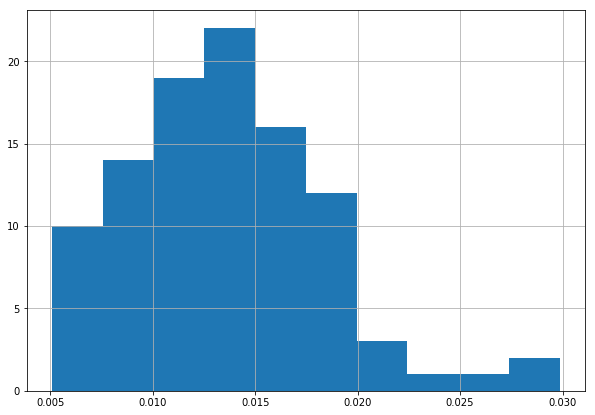

In [8]:
td = model_data.as_test_data_generator(model)
td.on_epoch_end()
td.accuracy["epoch"].hist(figsize=(10, 7))